In [3]:
import os
# Set thread usage BEFORE importing tensorflow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["OMP_NUM_THREADS"] = "48"
os.environ["TF_NUM_INTRAOP_THREADS"] = "48"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

import tensorflow.keras as keras  # Use tf.keras instead of standalone keras
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(48)
tf.config.threading.set_inter_op_parallelism_threads(4)

# Confirm thread settings
print("Intra-op threads:", tf.config.threading.get_intra_op_parallelism_threads())
print("Inter-op threads:", tf.config.threading.get_inter_op_parallelism_threads())

from tensorflow.keras import layers, Model, Input, activations, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset
import tensorflow_probability as tfp
import random, pickle, joblib, numpy as np, wandb, pandas as pd
from wandb.integration.keras import WandbCallback
tfd = tfp.distributions

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext' : True,
    'font.family': 'cmr10',
    'font.size': 15,
    'axes.labelsize': 17,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.dpi': 150
})

2025-07-20 18:55:47.280311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 18:55:47.284096: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 18:55:47.288960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 18:55:47.303345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753030547.327427 3749917 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753030547.33

Intra-op threads: 48
Inter-op threads: 4


2025-07-20 18:55:51.107489: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
class MixtureDensityOutput(tf.keras.layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = tf.keras.layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        ) # mix*output vals, no activation
        self.mdn_sigmas = tf.keras.layers.Dense(
            self.num_mix * self.output_dim,
            activation='exponential', #elu_plus_one_plus_epsilon,,
            name="mdn_sigmas",
        ) # mix*output vals exp activation
        self.mdn_pi = tf.keras.layers.Dense(self.num_mix, name="mdn_pi") # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )
    
    def call(self, x):
        return tf.concat(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], axis=-1, name="mdn_outputs"
        )
    
    def compute_output_shape(self, input_shape):
        # input_shape is (batch_size, dense_units)
        batch_size = input_shape[0]
        total_dim  = (2 * self.num_mix * self.output_dim) + self.num_mix
        return (batch_size, total_dim)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dimension": self.output_dim,
            "num_mixtures": self.num_mix
        })
        return config

def get_mixture_loss_func(output_dim, num_mixes, lambda_mse=0.1):
    def mdn_loss_func(y_true, y_pred):
        y_pred = tf.reshape(y_pred, [-1, (2 * num_mixes * output_dim) + num_mixes])
        y_true = tf.reshape(y_true, [-1, output_dim])

        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            [num_mixes * output_dim, num_mixes * output_dim, num_mixes],
            axis=-1
        )

        out_mu = tf.reshape(out_mu, [-1, num_mixes, output_dim])
        out_sigma = tf.reshape(out_sigma, [-1, num_mixes, output_dim])

        cat = tfd.Categorical(logits=out_pi)
        mvn = tfd.MultivariateNormalDiag(loc=out_mu, scale_diag=out_sigma)
        mixture = tfd.MixtureSameFamily(mixture_distribution=cat,
                                        components_distribution=mvn)

        nll = -mixture.log_prob(y_true)
        mdn_nll = tf.reduce_mean(nll)

        pi = tf.nn.softmax(out_pi, axis=-1)
        pi_exp = tf.expand_dims(pi, axis=-1)
        mean_weighted = tf.reduce_sum(pi_exp * out_mu, axis=1)

        mse = tf.reduce_mean(tf.square(mean_weighted - y_true))

        return mdn_nll + lambda_mse * mse
    return mdn_loss_func

In [5]:
# ─── 3) HELPER FUNCTIONS (from the Keras MDN recipe) ───────────────────
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    print("Error sampling categorical model.")
    return -1

def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

def sample_sequences(y_pred, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    batch, T, _ = y_pred.shape
    samples = np.zeros((batch, T, output_dim), dtype=np.float32)
    for b in range(batch):
        for t in range(T):
            samples[b,t] = sample_from_output(
                y_pred[b,t], output_dim, num_mixes,
                temp=temp, sigma_temp=sigma_temp
            )
    return samples

def sample_fan(y_pred, output_dim, num_mixes, N_samples,
               temp=1.0, sigma_temp=1.0):
    batch, T, _ = y_pred.shape
    fan = np.zeros((batch, N_samples, T, output_dim), dtype=np.float32)
    for n in range(N_samples):
        fan[:,n] = sample_sequences(
            y_pred, output_dim, num_mixes,
            temp=temp, sigma_temp=sigma_temp
        )
    return fan

In [6]:
import numpy as np

# WGS84 ellipsoid constants
WGS84_a = 6378137.0  # semi-major axis [m]
WGS84_f = 1/298.257223563  # flattening
WGS84_b = WGS84_a * (1 - WGS84_f)  # semi-minor axis [m]
WGS84_e = np.sqrt(1 - (WGS84_b**2)/(WGS84_a**2))  # eccentricity

def lla_to_ecef(lat, lon, alt):
    """
    Convert latitude, longitude, altitude to ECEF coordinates.
    
    Parameters
    ----------
    lat : float or array-like
        Latitude in degrees
    lon : float or array-like
        Longitude in degrees
    alt : float or array-like
        Altitude in meters
    
    Returns
    -------
    tuple
        (x, y, z) coordinates in ECEF system [meters]
    """
    # Convert to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Calculate N (radius of curvature in the prime vertical)
    N = WGS84_a / np.sqrt(1 - (WGS84_e * np.sin(lat_rad))**2)
    
    # Calculate ECEF coordinates
    x = (N + alt) * np.cos(lat_rad) * np.cos(lon_rad)
    y = (N + alt) * np.cos(lat_rad) * np.sin(lon_rad)
    z = (N * (1 - WGS84_e**2) + alt) * np.sin(lat_rad)
    
    return x, y, z

In [7]:
VERSION = "v4"
SUBVERSION = "v4"
RUN_ID = "14"

BATCH_SIZE = 512
NUM_MIXTURES = 3
LAMBDA_MSE = 0.2

base = f"/store/fusg/VT1/training/{VERSION}"
load = lambda split, kind: np.load(f"{base}/samples/{split}_{kind}_{SUBVERSION}.npy",
                                   allow_pickle=True).astype("float32")

with open(f"{base}/variables/scaler_in.pkl",  "rb") as f: scaler_in  = pickle.load(f)
with open(f"{base}/variables/scaler_out.pkl", "rb") as f: scaler_out = pickle.load(f)

train_var = load("train", "in_var")
train_con = load("train", "in_con")
train_out = load("train", "out")

val_var   = load("val",   "in_var")
val_con   = load("val",   "in_con")
val_out   = load("val",   "out")

test_var  = load("test",  "in_var")
test_con  = load("test",  "in_con")
test_out  = load("test",  "out")

TIME_STEPS_IN  = train_var.shape[1]
TIME_STEPS_OUT = train_out.shape[1]
VARIABLE_FEATURES = train_var.shape[2]
CONSTANT_FEATURES = train_con.shape[2]
OUTPUT_FEATURES = 3

model = tf.keras.models.load_model(
    f"/store/fusg/VT1/training/models/VT1_LSTM_MDN_Run_{RUN_ID}.keras",
    custom_objects={
        "MixtureDensityOutput": MixtureDensityOutput,
        "mdn_loss_func": get_mixture_loss_func(OUTPUT_FEATURES, NUM_MIXTURES, lambda_mse=LAMBDA_MSE)
    },
    compile=False
)

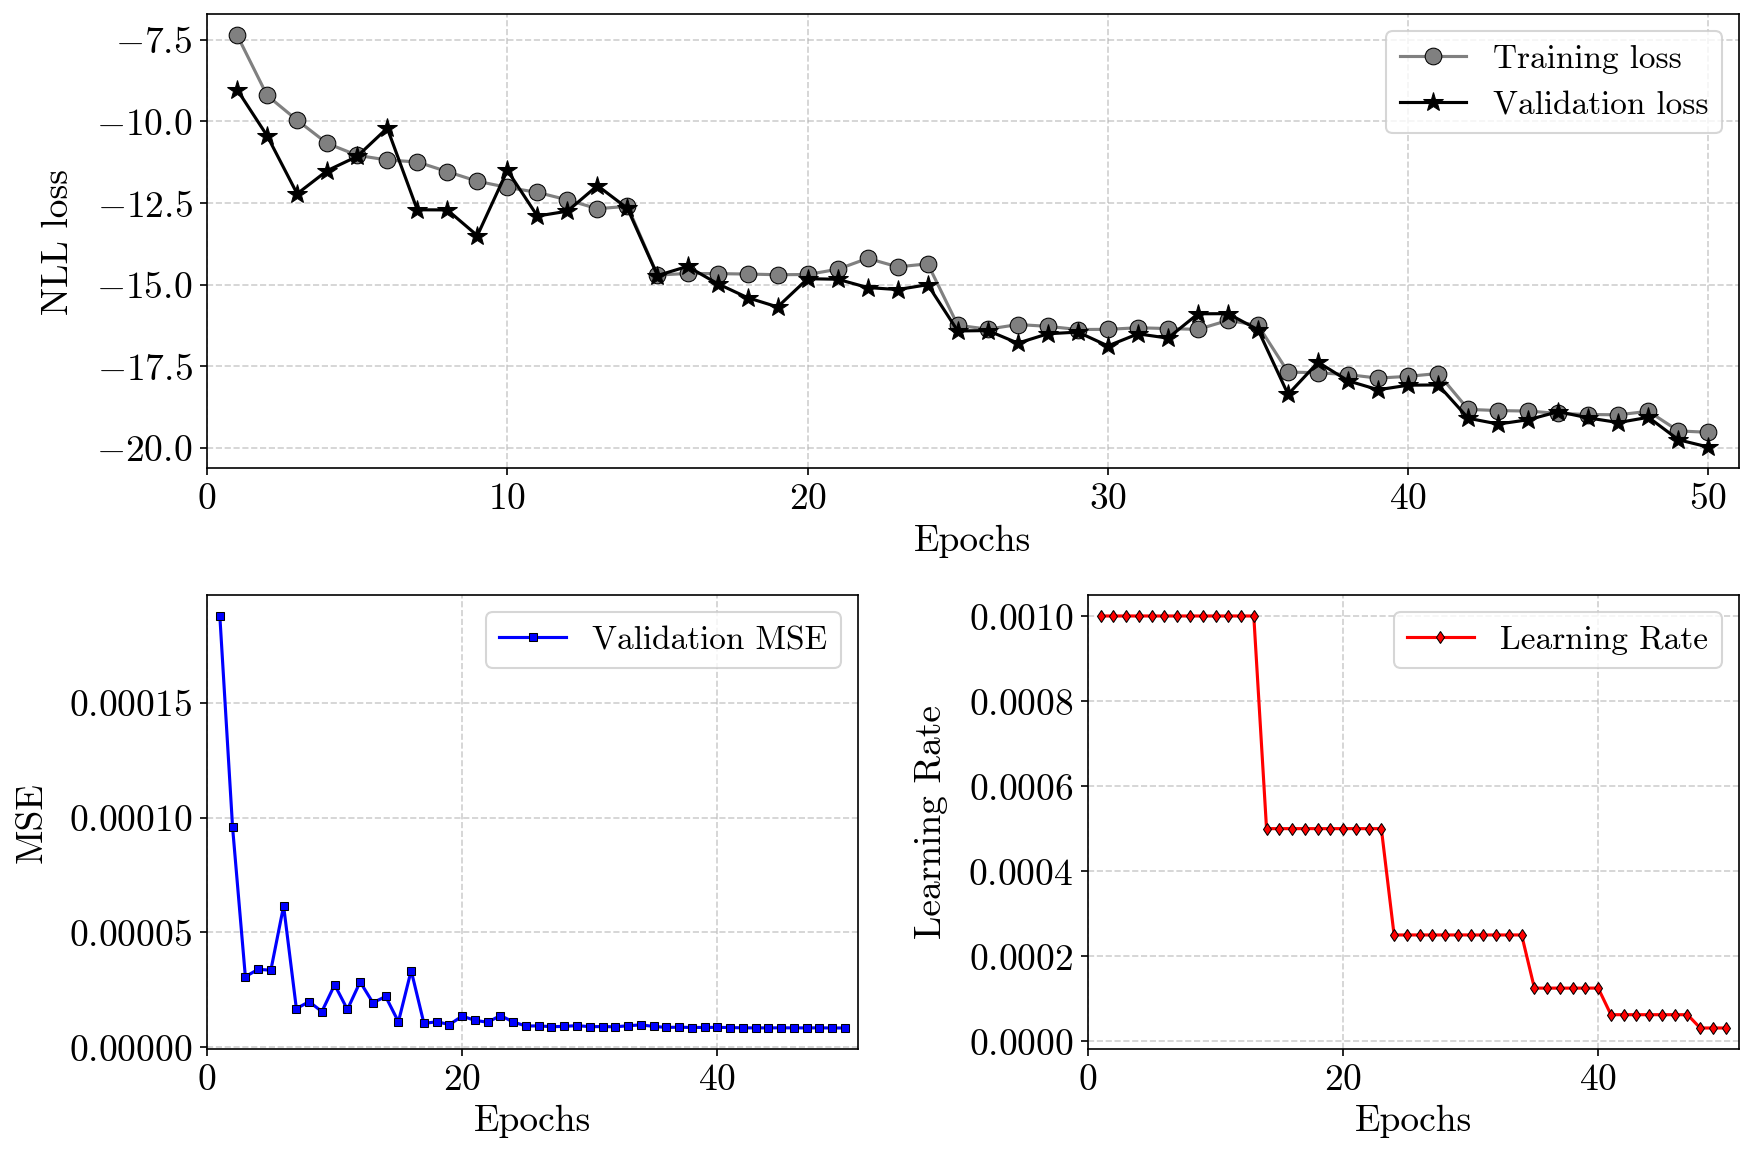

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
file_path = f'/store/fusg/VT1/training/models/LSTM_history_run_14.csv'
val_mse_path = f'/store/fusg/VT1/training/models/MSE_val_Run_14.csv'
lerning_rate_path = f'/store/fusg/VT1/training/models/LR_Run_14.csv'

df = pd.read_csv(file_path)
df_val_mse = pd.read_csv(val_mse_path)
df_lr = pd.read_csv(lerning_rate_path)

# Ensure the columns exist
if 'loss' not in df.columns or 'val_loss' not in df.columns:
    raise ValueError("CSV file must contain 'loss' and 'val_loss' columns.")

# Create a figure with subplots: 1 on top, 2 on bottom
fig = plt.figure(figsize=(12, 8))

# Top plot: Training and Validation Loss (Run_14)
ax1 = plt.subplot(2, 1, 1)
plt.plot(df.index+1, df['loss'], marker='o', linestyle='-', color='gray', label='Training loss', markersize=8, markeredgecolor='black', markeredgewidth=0.5)
plt.plot(df.index+1, df['val_loss'], marker='*', linestyle='-', color='black', label='Validation loss', markersize=10, markeredgecolor='black', markeredgewidth=0.5)
#plt.title(f'Run #14 - Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('NLL loss', fontsize=18, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)
plt.xlim(0, len(df)+1)

# Bottom left plot: Validation MSE
ax2 = plt.subplot(2, 2, 3)
plt.plot(df_val_mse.index+1, df_val_mse.iloc[:, 1], marker='s', linestyle='-', color='blue', label='Validation MSE', markersize=4, markeredgecolor='black', markeredgewidth=0.5)
#plt.title(f'Run #14 - Validation MSE', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('MSE',  fontsize=18, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)
plt.xlim(0, len(df_val_mse)+1)

# Bottom right plot: Learning Rate
ax3 = plt.subplot(2, 2, 4)
plt.plot(df_lr.index+1, df_lr.iloc[:, 1], marker='d', linestyle='-', color='red', label='Learning Rate', markersize=4, markeredgecolor='black', markeredgewidth=0.5)
#plt.title(f'Run #14 - Learning Rate', fontsize=16)
plt.xlabel('Epochs')

plt.ylabel('Learning Rate', fontsize=18, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)
plt.xlim(0, len(df_lr)+1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Inference Plots

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


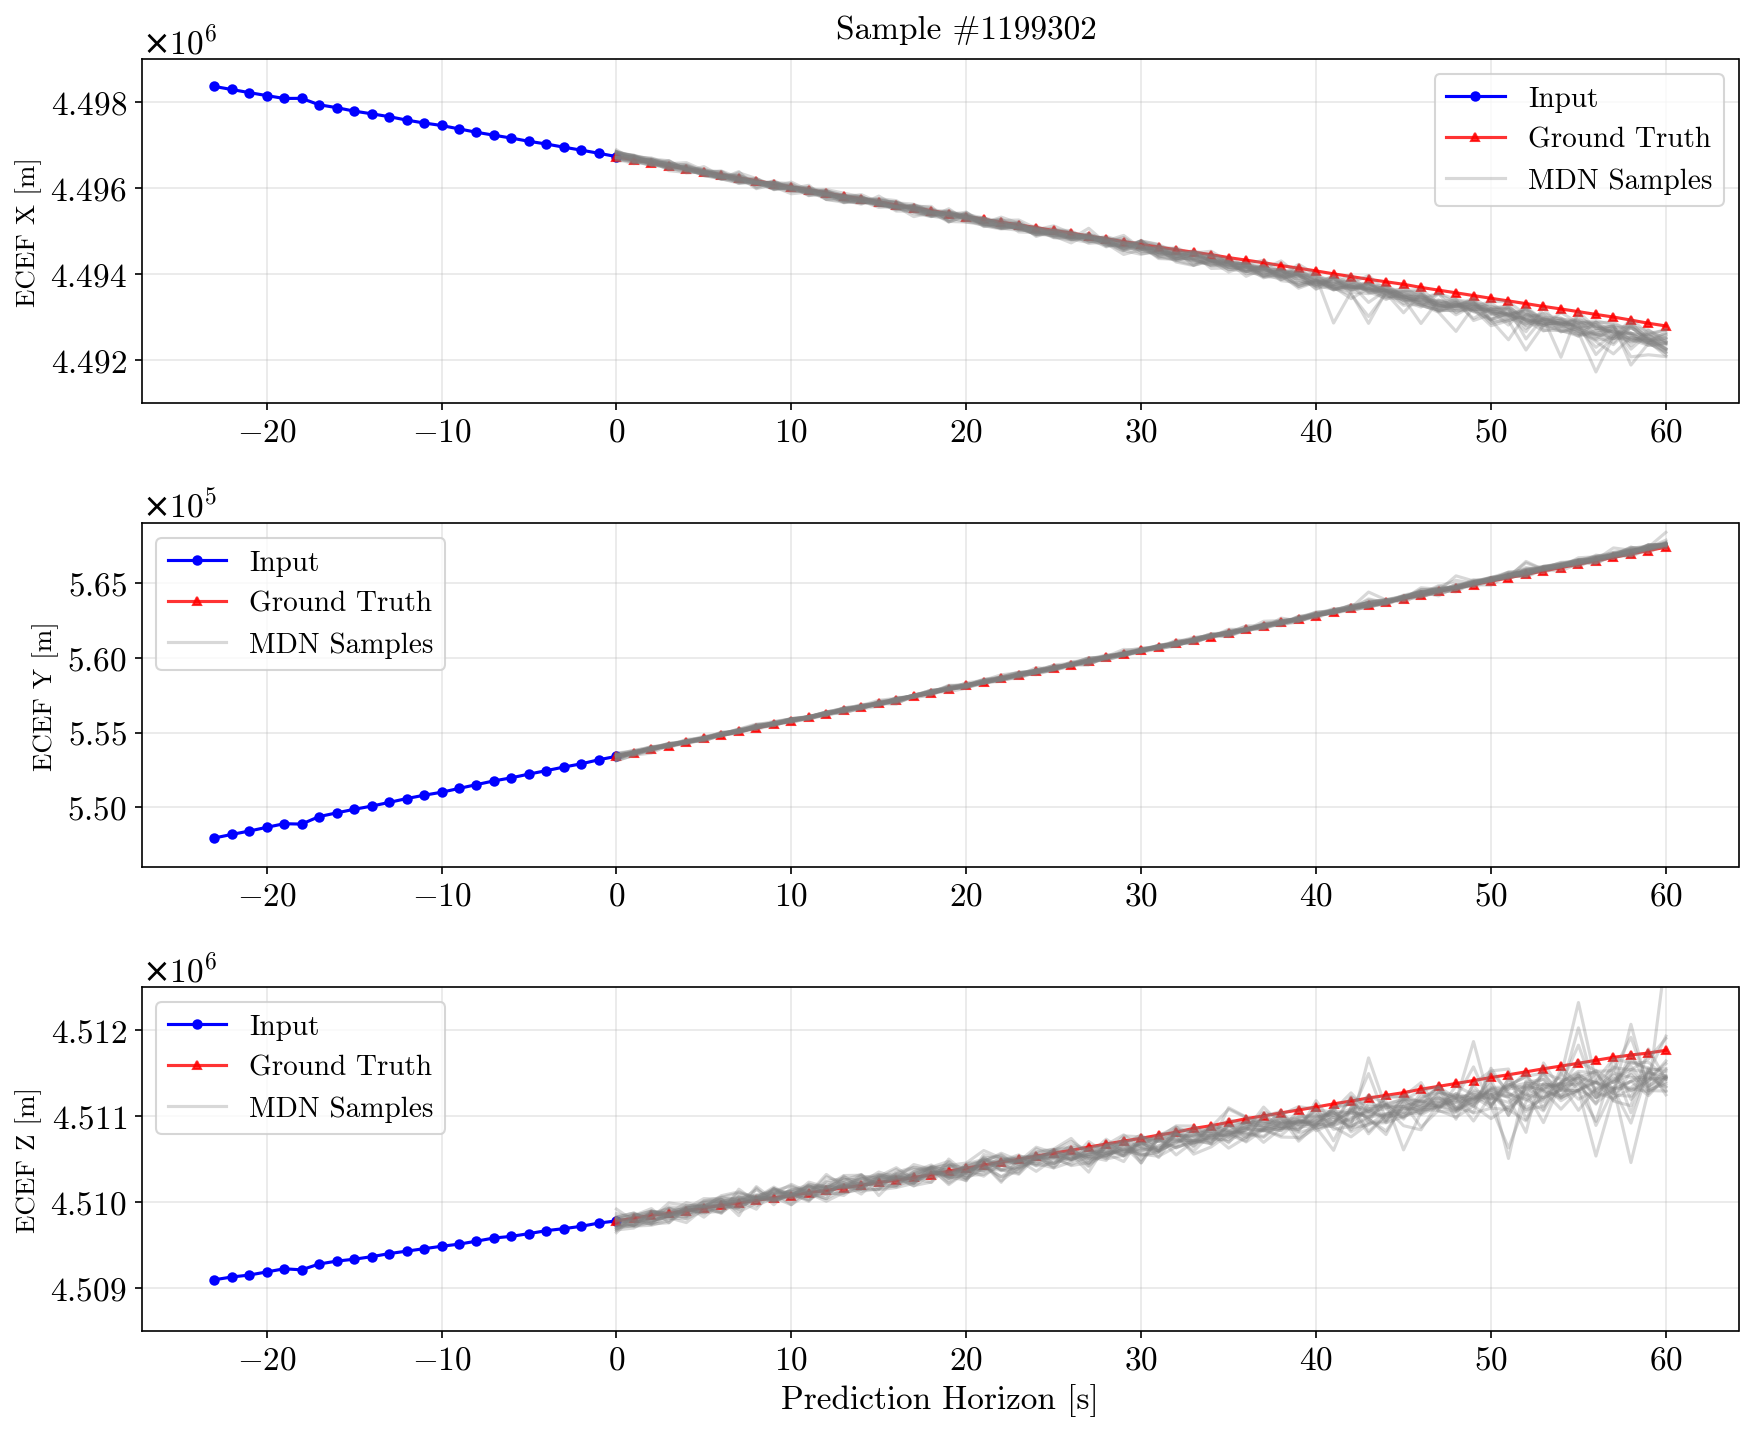

In [79]:
# FOR LSTM WITH MDN - CONVERTED TO ECEF COORDINATES
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sample_idx = random.randint(0, len(test_var) - 1)
#sample_idx = 153298
#sample_idx = 41008
#sample_idx = 310519
#sample_idx = 71362
#sample_idx = 1090834
#sample_idx = 755828
#sample_idx = 688672
sample_idx = 1199302

# (1, T_in, VARS)
x_enc = test_var[sample_idx:sample_idx+1, :, :]   # (1, T_in, VARS)
c_enc = test_con[sample_idx:sample_idx+1, :, :]   # (1, CONST_FEATS)
y_true = test_out[sample_idx, :, :]  # (T_out, 3)

y_pred_params = model.predict([x_enc, c_enc])      # (1, T_out, PARAMS)

N_SAMPLES = 25
mdn_samples = sample_fan(y_pred_params, OUTPUT_FEATURES, NUM_MIXTURES, N_SAMPLES, temp=0.25, sigma_temp=1.0)

K = 1 # Batch size (from x_enc, which is 1)
T_out = y_true.shape[0] # Number of time steps in the output
D = OUTPUT_FEATURES # Number of output features (e.g., 3 for lat/lon/alt)
num_in_cols = 8 # As provided in your request

flat_preds = mdn_samples[0].reshape(-1, D) # Reshape (1, N_SAMPLES, T_out, D) to (N_SAMPLES * T_out, D)
true_output_scaled = y_true # y_true is already your scaled true output
sample_var_scaled = x_enc[0, :, :] # Extract the single sample's input variables (T_in, VARS)

pred_unscaled = scaler_out.inverse_transform(flat_preds).reshape(N_SAMPLES, T_out, D)
true_unscaled = scaler_out.inverse_transform(true_output_scaled[:, :3])
input_unscaled = scaler_in.inverse_transform(sample_var_scaled[:, :num_in_cols])[:, :D]

# 🎯 CONVERT TO ECEF COORDINATES
# Convert input trajectory to ECEF
input_ecef_x, input_ecef_y, input_ecef_z = lla_to_ecef(input_unscaled[:, 0], input_unscaled[:, 1], input_unscaled[:, 2])
input_ecef = np.column_stack([input_ecef_x, input_ecef_y, input_ecef_z])

# Convert ground truth to ECEF
true_ecef_x, true_ecef_y, true_ecef_z = lla_to_ecef(true_unscaled[:, 0], true_unscaled[:, 1], true_unscaled[:, 2])
true_ecef = np.column_stack([true_ecef_x, true_ecef_y, true_ecef_z])

# Convert predictions to ECEF
pred_ecef = np.zeros((N_SAMPLES, T_out, 3))
for n in range(N_SAMPLES):
    pred_x, pred_y, pred_z = lla_to_ecef(pred_unscaled[n, :, 0], pred_unscaled[n, :, 1], pred_unscaled[n, :, 2])
    pred_ecef[n, :, :] = np.column_stack([pred_x, pred_y, pred_z])

# FOR LSTM WITH MDN - CONDENSED VERTICAL LAYOUT
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Model prediction and sampling
x_enc = test_var[sample_idx:sample_idx+1, :, :]
c_enc = test_con[sample_idx:sample_idx+1, :, :]
y_true = test_out[sample_idx, :, :]
y_pred_params = model.predict([x_enc, c_enc])

N_SAMPLES = 25
mdn_samples = sample_fan(y_pred_params, OUTPUT_FEATURES, NUM_MIXTURES, N_SAMPLES, temp=0.25, sigma_temp=1.0)

# Data processing
flat_preds = mdn_samples[0].reshape(-1, OUTPUT_FEATURES)
pred_unscaled = scaler_out.inverse_transform(flat_preds).reshape(N_SAMPLES, y_true.shape[0], OUTPUT_FEATURES)
true_unscaled = scaler_out.inverse_transform(y_true[:, :3])
input_unscaled = scaler_in.inverse_transform(x_enc[0, :, :8])[:, :3]

# Convert to ECEF coordinates
input_ecef_x, input_ecef_y, input_ecef_z = lla_to_ecef(input_unscaled[:, 0], input_unscaled[:, 1], input_unscaled[:, 2])
input_ecef = np.column_stack([input_ecef_x, input_ecef_y, input_ecef_z])

true_ecef_x, true_ecef_y, true_ecef_z = lla_to_ecef(true_unscaled[:, 0], true_unscaled[:, 1], true_unscaled[:, 2])
true_ecef = np.column_stack([true_ecef_x, true_ecef_y, true_ecef_z])

pred_ecef = np.zeros((N_SAMPLES, y_true.shape[0], 3))
for n in range(N_SAMPLES):
    pred_x, pred_y, pred_z = lla_to_ecef(pred_unscaled[n, :, 0], pred_unscaled[n, :, 1], pred_unscaled[n, :, 2])
    pred_ecef[n, :, :] = np.column_stack([pred_x, pred_y, pred_z])

# Create condensed vertical subplot layout
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
coordinate_names = ['ECEF X [m]', 'ECEF Y [m]', 'ECEF Z [m]']

# Single main title for the entire figure
fig.suptitle(f"Sample #{sample_idx}", fontsize=16, y=0.96, x=0.55)

for j in range(3):
    ax = axes[j]
    
    # Plot trajectories
    ax.plot(range(-x_enc.shape[1]+1, 1), input_ecef[:, j], 'bo-', 
           label='Input', markersize=4)
    ax.plot(range(0, true_ecef.shape[0]), true_ecef[:, j], 'r^-', 
           label='Ground Truth', alpha=0.8, markersize=4)
    
    # Plot MDN samples
    for n in range(N_SAMPLES):
        ax.plot(range(0, true_ecef.shape[0]), pred_ecef[n, :, j], '-', color='gray', 
               alpha=0.3, linewidth=1.5, label='MDN Samples' if (n == 0) else '')
    
    # Formatting
    ax.set_ylabel(coordinate_names[j], fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(-20, true_ecef.shape[0]+1, 10))
        
    # Only show legend on top plot
    ax.legend(fontsize=14, loc='best')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Only show x-label on bottom plot
    if j == 2:
        ax.set_xlabel("Prediction Horizon [s]", fontsize=16)
    
    # Set y-limits
    if j == 0:
        ax.set_ylim([4491000, 4499000])
        #factor = 0.0005
        #ax.set_ylim([np.min(pred_ecef[:, :, j])*(1-factor), np.max(pred_ecef[:, :, j])*(1+factor)])
    elif j == 1:
        ax.set_ylim([546000, 569000])
        #factor = 0.0005
        #ax.set_ylim([np.min(pred_ecef[:, :, j])*(1-factor), np.max(pred_ecef[:, :, j])*(1+factor)])
    else:
        ax.set_ylim([4508500, 4512500])
        #factor = 0.0005
        #ax.set_ylim([np.min(pred_ecef[:, :, j])*(1-factor), np.max(pred_ecef[:, :, j])*(1+factor)])
    
    # Format y-axis with commas for large numbers
    #ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Make room for main title
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


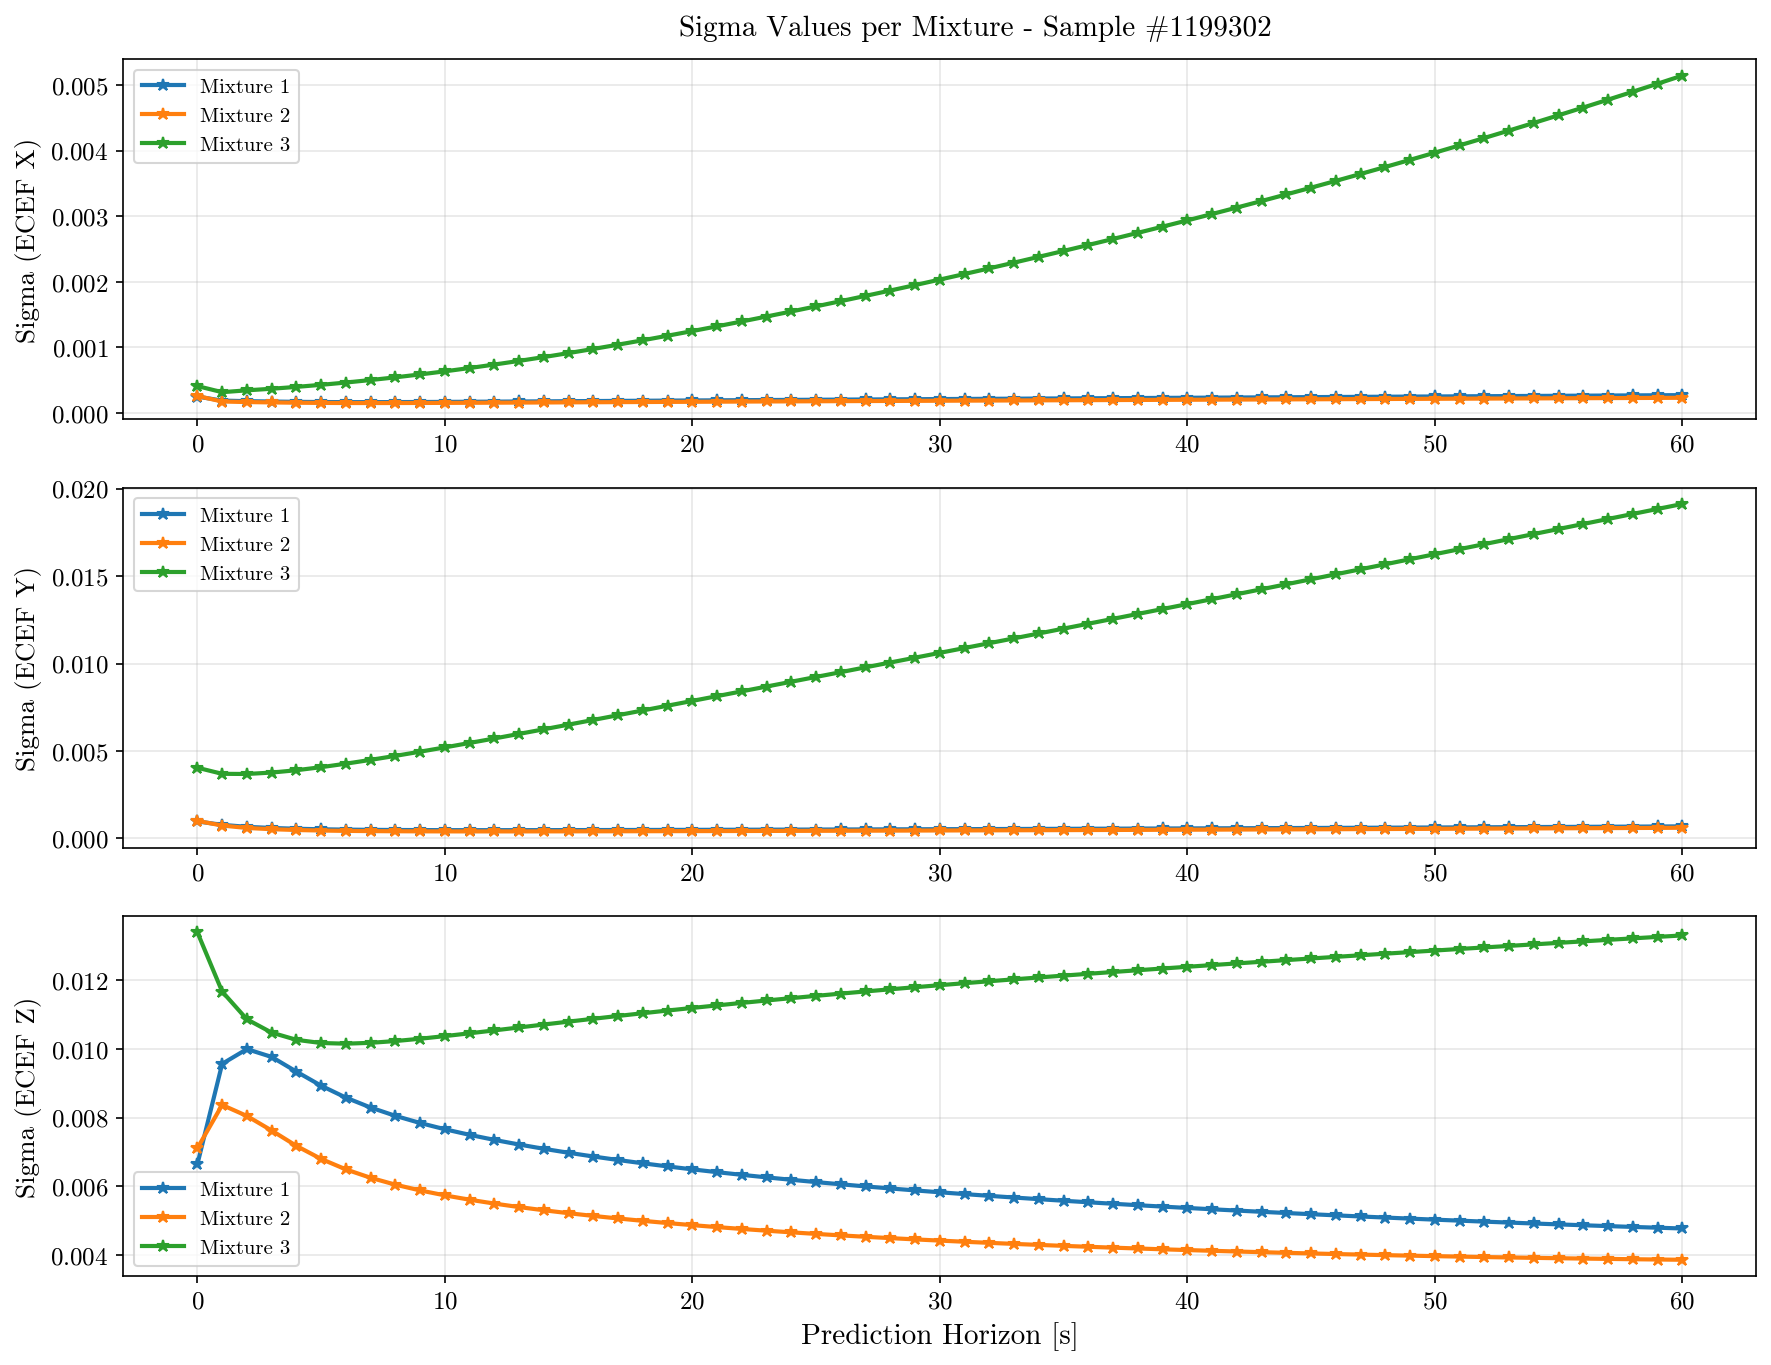

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Get your MDN outputs: shape (1, T_out, num_mixtures * output_dim * 3)
mdn_pred = model.predict([x_enc, c_enc])  # shape: (1, T_out, ...)
mdn_pred = mdn_pred[0, :]  # Remove batch dim: (T_out, num_mixtures * output_dim * 3)

num_mixtures = NUM_MIXTURES
output_dim = 3  # latitude, longitude, altitude

# Helper to extract sigma values for one output dimension
def extract_sigmas(mdn_pred, dim, num_mixtures, output_dim):
    T_out = mdn_pred.shape[0]
    sigma_start = num_mixtures * output_dim
    sigma_end = 2 * num_mixtures * output_dim
    sigmas = []
    for t in range(T_out):
        s = []
        for k in range(num_mixtures):
            idx = sigma_start + dim * num_mixtures + k
            s.append(mdn_pred[t, idx])
        sigmas.append(s)
    return np.array(sigmas)  # shape: (T_out, num_mixtures)

output_names = ['ECEF X', 'ECEF Y', 'ECEF Z']

# Create condensed vertical subplot layout (similar to Cell 9)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Single main title for the entire figure
fig.suptitle(f"Sigma Values per Mixture - Sample #{sample_idx}", fontsize=14, y=0.91, x =0.55)

for dim, name in enumerate(output_names):
    ax = axes[dim]
    sigmas = extract_sigmas(mdn_pred, dim, num_mixtures, output_dim)  # shape: (T_out, num_mixtures)
    
    # Plot sigma values for each mixture
    for k in range(num_mixtures):
        ax.plot(range(sigmas.shape[0]), sigmas[:, k], marker='*', 
               label=f'Mixture {k+1}', markersize=6, linewidth=2)
    
    # Formatting
    ax.set_ylabel(f'Sigma ({name})', fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, sigmas.shape[0]+1, 10))
    
    # Only show legend on all plots (since they're informative)
    ax.legend(fontsize=10, loc='best')
    
    # Only show x-label on bottom plot
    if dim == 2:
        ax.set_xlabel("Prediction Horizon [s]", fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Make room for main title
plt.show()

In [10]:
# Quantitative assessment of mixture collapse
import numpy as np

# Extract sigma values for analysis
def assess_mixture_collapse(mdn_pred, num_mixtures, output_dim, threshold_ratio=10.0, min_sigma=1e-6):
    """
    Assess if any mixture components are collapsing by analyzing sigma values.
    
    Parameters:
    - mdn_pred: MDN predictions (T_out, param_dim)
    - num_mixtures: number of mixture components
    - output_dim: output dimensions
    - threshold_ratio: max ratio between largest and smallest sigma
    - min_sigma: minimum acceptable sigma value
    
    Returns:
    - collapse_detected: bool indicating if collapse is detected
    - statistics: dict with detailed analysis
    """
    
    T_out = mdn_pred.shape[0]
    sigma_start = num_mixtures * output_dim
    
    # Storage for all sigma values
    all_sigmas = np.zeros((T_out, output_dim, num_mixtures))
    
    # Extract all sigma values
    for t in range(T_out):
        for dim in range(output_dim):
            for k in range(num_mixtures):
                idx = sigma_start + dim * num_mixtures + k
                all_sigmas[t, dim, k] = mdn_pred[t, idx]
    
    # Analysis results
    stats = {}
    collapse_detected = False
    
    print("🔍 MIXTURE COLLAPSE ANALYSIS")
    print("=" * 50)
    
    for dim in range(output_dim):
        dim_name = ['X', 'Y', 'Z'][dim]
        print(f"\n📊 DIMENSION {dim_name}:")
        
        # Get sigma values for this dimension across all timesteps
        dim_sigmas = all_sigmas[:, dim, :]  # (T_out, num_mixtures)
        
        # Calculate statistics for each mixture
        mixture_stats = {}
        for k in range(num_mixtures):
            mixture_sigmas = dim_sigmas[:, k]
            
            mean_sigma = np.mean(mixture_sigmas)
            std_sigma = np.std(mixture_sigmas)
            min_sigma_val = np.min(mixture_sigmas)
            max_sigma_val = np.max(mixture_sigmas)
            
            mixture_stats[k] = {
                'mean': mean_sigma,
                'std': std_sigma,
                'min': min_sigma_val,
                'max': max_sigma_val,
                'range': max_sigma_val - min_sigma_val
            }
            
            print(f"  Mixture {k+1}: mean={mean_sigma:.6f}, std={std_sigma:.6f}, "
                  f"min={min_sigma_val:.6f}, max={max_sigma_val:.6f}")
        
        # Check for collapse indicators
        means = [mixture_stats[k]['mean'] for k in range(num_mixtures)]
        stds = [mixture_stats[k]['std'] for k in range(num_mixtures)]
        mins = [mixture_stats[k]['min'] for k in range(num_mixtures)]
        
        # Test 1: Very small sigma values
        very_small_count = sum(1 for mean_val in means if mean_val < min_sigma)
        if very_small_count > 0:
            print(f"  ⚠️  {very_small_count} mixture(s) have very small sigma (< {min_sigma})")
            collapse_detected = True
        
        # Test 2: Large ratio between max and min sigma
        if max(means) > 0:
            sigma_ratio = max(means) / min(means)
            print(f"  📈 Sigma ratio (max/min): {sigma_ratio:.2f}")
            if sigma_ratio > threshold_ratio:
                print(f"  ⚠️  Large sigma ratio detected (> {threshold_ratio})")
                collapse_detected = True
        
        # Test 3: Very low variance (constant sigma over time)
        low_variance_count = sum(1 for std_val in stds if std_val < min_sigma/10)
        if low_variance_count > 0:
            print(f"  ⚠️  {low_variance_count} mixture(s) have very low variance (nearly constant)")
        
        # Test 4: Check if mixtures are too similar
        mixture_similarity = []
        for i in range(num_mixtures):
            for j in range(i+1, num_mixtures):
                diff = abs(means[i] - means[j])
                similarity = 1 - (diff / max(means[i], means[j])) if max(means[i], means[j]) > 0 else 1
                mixture_similarity.append(similarity)
        
        if mixture_similarity:
            max_similarity = max(mixture_similarity)
            print(f"  🔄 Maximum mixture similarity: {max_similarity:.3f}")
            if max_similarity > 0.95:
                print(f"  ⚠️  Mixtures are very similar (> 95% similar)")
        
        stats[dim_name] = {
            'mixture_stats': mixture_stats,
            'sigma_ratio': sigma_ratio if max(means) > 0 else 0,
            'very_small_count': very_small_count,
            'low_variance_count': low_variance_count,
            'max_similarity': max(mixture_similarity) if mixture_similarity else 0
        }
    
    print("\n🎯 OVERALL ASSESSMENT:")
    if collapse_detected:
        print("❌ MIXTURE COLLAPSE DETECTED!")
        print("   - Some mixtures may not be contributing effectively")
        print("   - Consider adjusting loss function or model architecture")
    else:
        print("✅ NO MIXTURE COLLAPSE DETECTED")
        print("   - All mixtures appear to be active and contributing")
        print("   - Model is using the full mixture capacity")
    
    return collapse_detected, stats

# Run the analysis on your current sample
collapse_detected, detailed_stats = assess_mixture_collapse(
    mdn_pred, NUM_MIXTURES, output_dim, 
    threshold_ratio=10.0, min_sigma=1e-6
)

# Additional check: Analyze mixture weights (pi values)
print("\n🎲 MIXTURE WEIGHT ANALYSIS:")
print("=" * 30)

# Extract pi values and analyze their distribution
pi_start = 2 * NUM_MIXTURES * output_dim
for t in range(min(10, mdn_pred.shape[0])):  # Check first 10 timesteps
    pi_logits = mdn_pred[t, pi_start:]
    pi_weights = softmax(pi_logits)
    
    print(f"Timestep {t+1}: weights = {pi_weights}")
    
    # Check if any mixture is completely dominated
    max_weight = np.max(pi_weights)
    min_weight = np.min(pi_weights)
    
    if max_weight > 0.95:
        print(f"  ⚠️  One mixture dominates (weight = {max_weight:.3f})")
    if min_weight < 0.01:
        print(f"  ⚠️  One mixture barely contributes (weight = {min_weight:.3f})")

print("\n📋 SUMMARY:")
print(f"Collapse detected: {collapse_detected}")
print(f"Number of mixtures: {NUM_MIXTURES}")
print(f"All mixtures active: {not collapse_detected}")

🔍 MIXTURE COLLAPSE ANALYSIS

📊 DIMENSION X:
  Mixture 1: mean=0.000214, std=0.000033, min=0.000165, max=0.000272
  Mixture 2: mean=0.000189, std=0.000026, min=0.000151, max=0.000259
  Mixture 3: mean=0.002252, std=0.001464, min=0.000317, max=0.005142
  📈 Sigma ratio (max/min): 11.90
  ⚠️  Large sigma ratio detected (> 10.0)
  🔄 Maximum mixture similarity: 0.882

📊 DIMENSION Y:
  Mixture 1: mean=0.000566, std=0.000088, min=0.000473, max=0.000973
  Mixture 2: mean=0.000494, std=0.000097, min=0.000401, max=0.001002
  Mixture 3: mean=0.010760, std=0.004764, min=0.003685, max=0.019123
  📈 Sigma ratio (max/min): 21.77
  ⚠️  Large sigma ratio detected (> 10.0)
  🔄 Maximum mixture similarity: 0.873

📊 DIMENSION Z:
  Mixture 1: mean=0.006254, std=0.001363, min=0.004774, max=0.009995
  Mixture 2: mean=0.004848, std=0.001103, min=0.003864, max=0.008369
  Mixture 3: mean=0.011825, std=0.000986, min=0.010153, max=0.013393
  📈 Sigma ratio (max/min): 2.44
  🔄 Maximum mixture similarity: 0.775

🎯 OVER

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


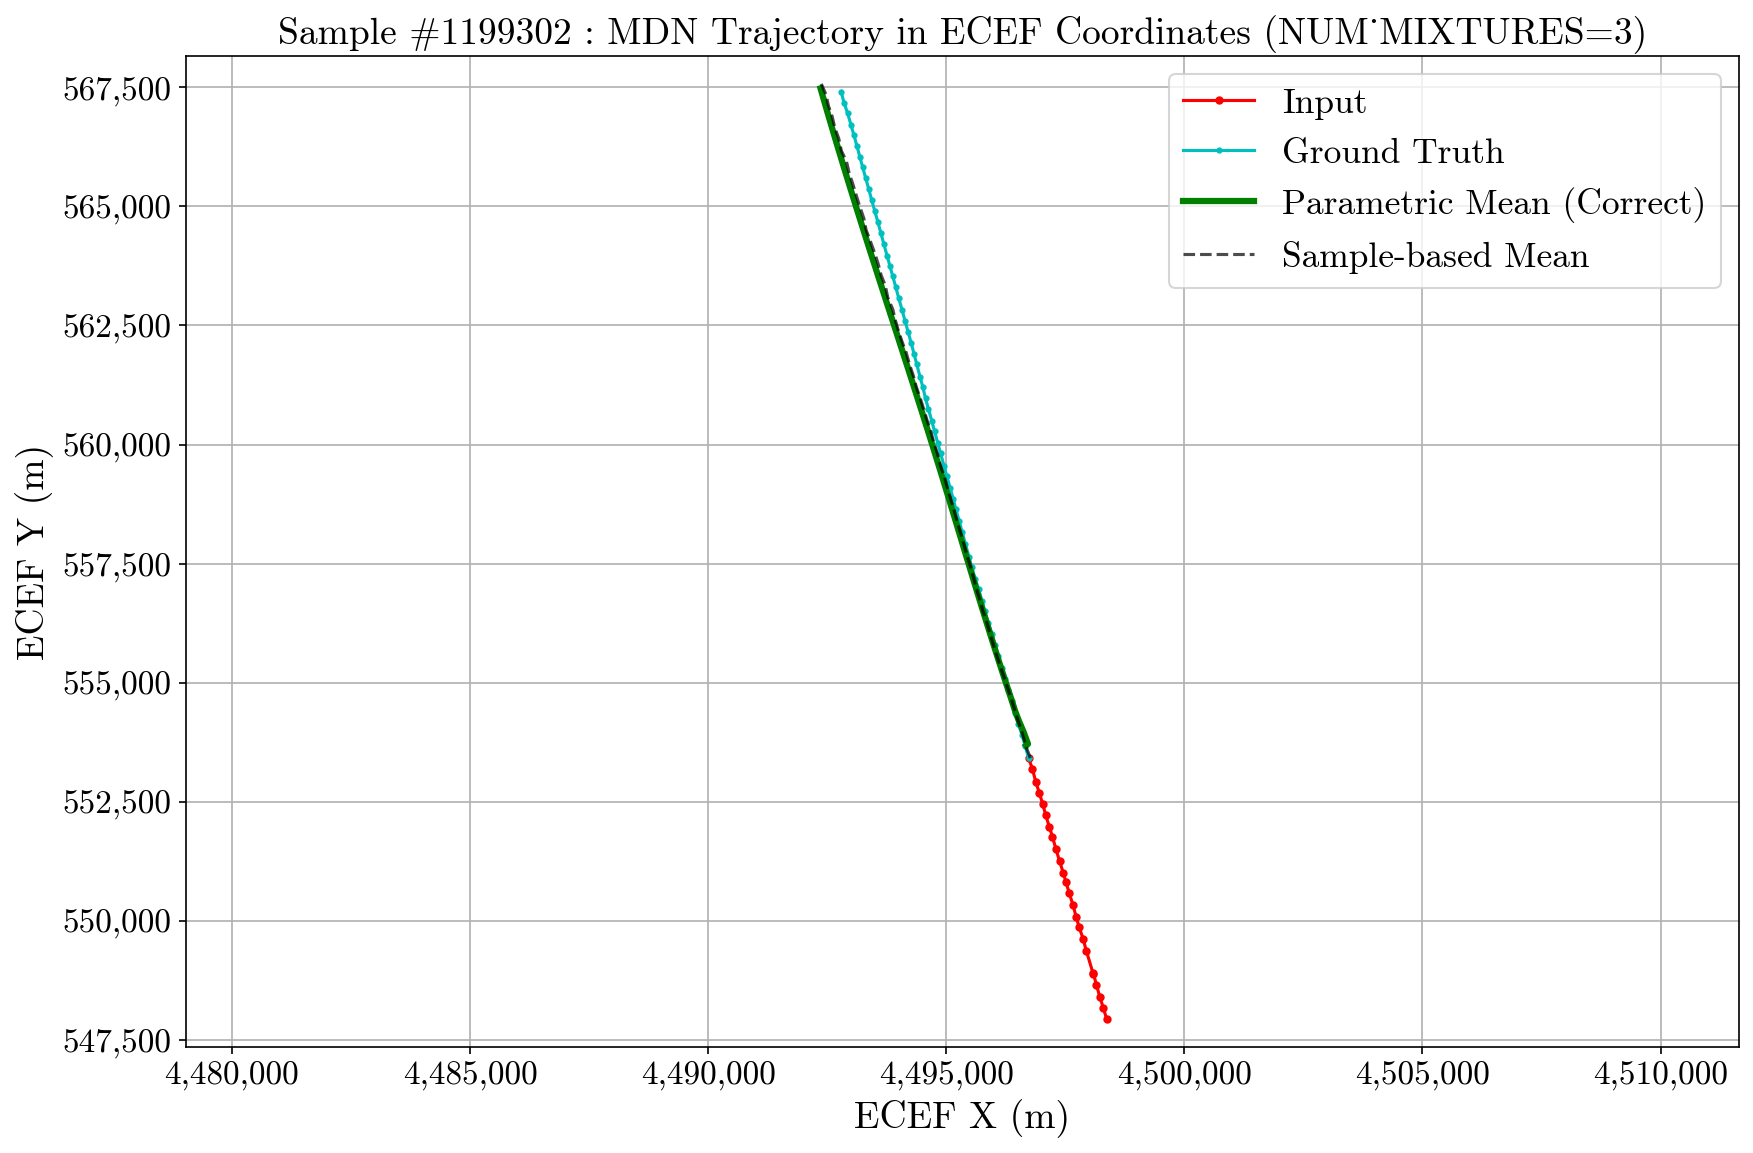

DIAGNOSTIC ANALYSIS - ECEF Coordinates
Model architecture: MDN (NUM_MIXTURES=3)
Using temperatures: temp=0.25, sigma_temp=1.0

Parametric vs Sample mean difference (ECEF):
  - X: 41.57 m (should be ~0)
  - Y: 29.69 m (should be ~0)

Ground truth vs Parametric mean error (ECEF):
  - X: 191.16 m
  - Y: 35.30 m

Trajectory analysis (ECEF):
  - Input avg speed:     250.36 m/timestep
  - GT avg speed:        242.49 m/timestep
  - Predicted avg speed: 241.53 m/timestep


In [35]:
# Fix for Cell 11 - Correct the fan array indexing
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter

# Get the same sample data used in previous cells
#sample_idx = random.randint(0, len(test_var) - 1)  # Or use a specific index
x_enc = test_var[sample_idx:sample_idx+1, :, :]
c_enc = test_con[sample_idx:sample_idx+1, :, :]
y_true = test_out[sample_idx, :, :]

# Make prediction and get parametric mean
y_pred_params = model.predict([x_enc, c_enc])
N_SAMPLES = 200
K = N_SAMPLES
temp = 0.25
sigma_temp = 1.0

# Generate fan samples
fan = sample_fan(y_pred_params, OUTPUT_FEATURES, NUM_MIXTURES, K, temp=temp, sigma_temp=sigma_temp)

# Get parametric mean by extracting from MDN parameters
param_predictions = np.zeros((y_true.shape[0], OUTPUT_FEATURES))
for t in range(y_true.shape[0]):
    params_t = y_pred_params[0, t, :]
    mus, sigs, pi_logits = split_mixture_params(params_t, OUTPUT_FEATURES, NUM_MIXTURES)
    pis = softmax(pi_logits)
    mus = mus.reshape(NUM_MIXTURES, OUTPUT_FEATURES)
    weighted_mean = np.zeros(OUTPUT_FEATURES)
    for mix_idx in range(NUM_MIXTURES):
        weighted_mean += pis[mix_idx] * mus[mix_idx]
    param_predictions[t, :] = weighted_mean

# Unscale data
param_unscaled = scaler_out.inverse_transform(param_predictions)
gt_unscaled = scaler_out.inverse_transform(y_true[:, :3])
input_unscaled = scaler_in.inverse_transform(x_enc[0, :, :8])[:, :3]

# Convert to ECEF
history_ecef_x, history_ecef_y, history_ecef_z = lla_to_ecef(input_unscaled[:, 0], input_unscaled[:, 1], input_unscaled[:, 2])
history_ecef = np.column_stack([history_ecef_x, history_ecef_y, history_ecef_z])

gt_ecef_x, gt_ecef_y, gt_ecef_z = lla_to_ecef(gt_unscaled[:, 0], gt_unscaled[:, 1], gt_unscaled[:, 2])
gt_ecef = np.column_stack([gt_ecef_x, gt_ecef_y, gt_ecef_z])

param_ecef_x, param_ecef_y, param_ecef_z = lla_to_ecef(param_unscaled[:, 0], param_unscaled[:, 1], param_unscaled[:, 2])
param_ecef = np.column_stack([param_ecef_x, param_ecef_y, param_ecef_z])

# Get predicted sigmas (approximate)
predicted_sigmas = np.zeros((y_true.shape[0], OUTPUT_FEATURES))
for t in range(y_true.shape[0]):
    params_t = y_pred_params[0, t, :]
    mus, sigs, pi_logits = split_mixture_params(params_t, OUTPUT_FEATURES, NUM_MIXTURES)
    pis = softmax(pi_logits)
    sigs = sigs.reshape(NUM_MIXTURES, OUTPUT_FEATURES)
    # Use weighted average of sigmas as approximation
    weighted_sigma = np.zeros(OUTPUT_FEATURES)
    for mix_idx in range(NUM_MIXTURES):
        weighted_sigma += pis[mix_idx] * sigs[mix_idx]
    predicted_sigmas[t, :] = weighted_sigma

# Convert fan samples to ECEF - FIXED INDEXING
fan_ecef = np.zeros((K, TIME_STEPS_OUT, 3))
for k in range(K):
    # Correct way to access fan samples: fan[batch_idx, sample_idx, :, :]
    fan_unscaled = scaler_out.inverse_transform(fan[0, k, :, :])  # [0, k] not [k]
    fan_x, fan_y, fan_z = lla_to_ecef(fan_unscaled[:, 0], fan_unscaled[:, 1], fan_unscaled[:, 2])
    fan_ecef[k, :, :] = np.column_stack([fan_x, fan_y, fan_z])

# Compute per‐timestep mean from ECEF samples
ecef_x_samples = fan_ecef[:, :, 0]   # (K, T_out)
ecef_y_samples = fan_ecef[:, :, 1]   # (K, T_out)

mu_ecef_x_samples = ecef_x_samples.mean(axis=0)    # (T_out,)
mu_ecef_y_samples = ecef_y_samples.mean(axis=0)    # (T_out,)

# ─── 6) Plot everything on one spatial figure (ECEF X-Y plane) ───────────
plt.figure(figsize=(12, 8))

# a) Plot input trajectory (history) in ECEF
plt.plot(history_ecef[:,0], history_ecef[:,1], 'ro-', label='Input', markersize=3)

# b) Plot ground‐truth future trajectory in ECEF
plt.plot(gt_ecef[:,0], gt_ecef[:,1], 'c.-', label='Ground Truth', markersize=4)

# c) Plot PARAMETRIC mean (the theoretically correct one) in ECEF
plt.plot(param_ecef[:,0], param_ecef[:,1], 'g-', 
         label='Parametric Mean (Correct)', linewidth=3)

# d) Plot mean of MDN samples (for comparison) in ECEF
plt.plot(mu_ecef_x_samples, mu_ecef_y_samples, 'k--', 
         label='Sample-based Mean', alpha=0.7)

# e) At each output timestep, draw uncertainty ellipses in ECEF space
# Convert predicted sigmas to ECEF space (approximate)
sigma_unscaled = predicted_sigmas  # These are already in the unscaled coordinate space
for t in range(TIME_STEPS_OUT):
    # For ECEF, we approximate the uncertainty ellipse size
    # Note: This is a simplified approach - proper uncertainty propagation would be more complex
    ellipse_width = sigma_unscaled[t, 1] * 111320  # rough conversion from degrees to meters for longitude
    ellipse_height = sigma_unscaled[t, 0] * 111320  # rough conversion from degrees to meters for latitude
    
    ellipse = patches.Ellipse(
        (param_ecef[t, 0], param_ecef[t, 1]),
        width  = 2 * ellipse_width,    # full width = 2·σ
        height = 2 * ellipse_height,   # full height = 2·σ
        angle  = 0,
        alpha  = 0.15,
        facecolor='green',
        edgecolor='none'
    )
    plt.gca().add_patch(ellipse)

plt.xlabel("ECEF X (m)")
plt.ylabel("ECEF Y (m)")
plt.title(f"Sample #{sample_idx} : MDN Trajectory in ECEF Coordinates (NUM_MIXTURES={NUM_MIXTURES})")
plt.legend()
plt.grid()
plt.axis('equal')

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# ─── 7) DIAGNOSTIC ANALYSIS (Updated for ECEF) ───────────────────────────
print("="*60)
print("DIAGNOSTIC ANALYSIS - ECEF Coordinates")
print("="*60)

print(f"Model architecture: MDN (NUM_MIXTURES={NUM_MIXTURES})")
print(f"Using temperatures: temp={temp}, sigma_temp={sigma_temp}")

# Check if parametric vs sample means are consistent in ECEF
param_vs_sample_x = np.mean(np.abs(param_ecef[:,0] - mu_ecef_x_samples))
param_vs_sample_y = np.mean(np.abs(param_ecef[:,1] - mu_ecef_y_samples))
print(f"\nParametric vs Sample mean difference (ECEF):")
print(f"  - X: {param_vs_sample_x:.2f} m (should be ~0)")
print(f"  - Y: {param_vs_sample_y:.2f} m (should be ~0)")

# Check ground truth vs parametric mean error in ECEF
gt_vs_param_x = np.mean(np.abs(gt_ecef[:,0] - param_ecef[:,0]))
gt_vs_param_y = np.mean(np.abs(gt_ecef[:,1] - param_ecef[:,1]))
print(f"\nGround truth vs Parametric mean error (ECEF):")
print(f"  - X: {gt_vs_param_x:.2f} m")
print(f"  - Y: {gt_vs_param_y:.2f} m")

# Check trajectory characteristics in ECEF
input_velocity_ecef = np.diff(history_ecef[:, :2], axis=0)
gt_velocity_ecef = np.diff(gt_ecef[:, :2], axis=0)
pred_velocity_ecef = np.diff(param_ecef[:, :2], axis=0)

print(f"\nTrajectory analysis (ECEF):")
print(f"  - Input avg speed:     {np.mean(np.linalg.norm(input_velocity_ecef, axis=1)):.2f} m/timestep")
print(f"  - GT avg speed:        {np.mean(np.linalg.norm(gt_velocity_ecef, axis=1)):.2f} m/timestep")
print(f"  - Predicted avg speed: {np.mean(np.linalg.norm(pred_velocity_ecef, axis=1)):.2f} m/timestep")

print("="*60)

🎯 DENSITY MAP ANALYSIS - Understanding Model Predictions
📍 Analyzing sample #1027647 with 200 samples
🌡️ Temperature settings: temp=0.25, sigma_temp=1.0
✅ Collected 12200 sample points for density analysis
📊 X range: [4491139, 4497159] meters
📊 Y range: [553025, 568300] meters
📐 Total spatial area covered: 91959966 m²
🎨 Created 100×100 density grid
📈 Density range: [0.00e+00, 3.72e-07] per m²

🔍 UNDERSTANDING DENSITY VALUES:
❓ Why are density values so small (e.g., 1e-08)?
✅ This is NORMAL and expected! Here's why:
   • Density units: 1/m² (inverse square meters)
   • Total area: 91959966 m² (92.0 km²)
   • Total samples: 12,200 points
   • Average density: ~1.09e-08 per m²
   • What matters: RELATIVE density differences, not absolute values
   • High density = model thinks aircraft is MORE LIKELY to be there
   • Low density = model thinks aircraft is LESS LIKELY to be there
   • Density ratio (max/min): infx
   • This shows how much more likely some areas are vs others


/tmp/ipykernel_3749917/492351671.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  density_ratio = density.max() / density.min()


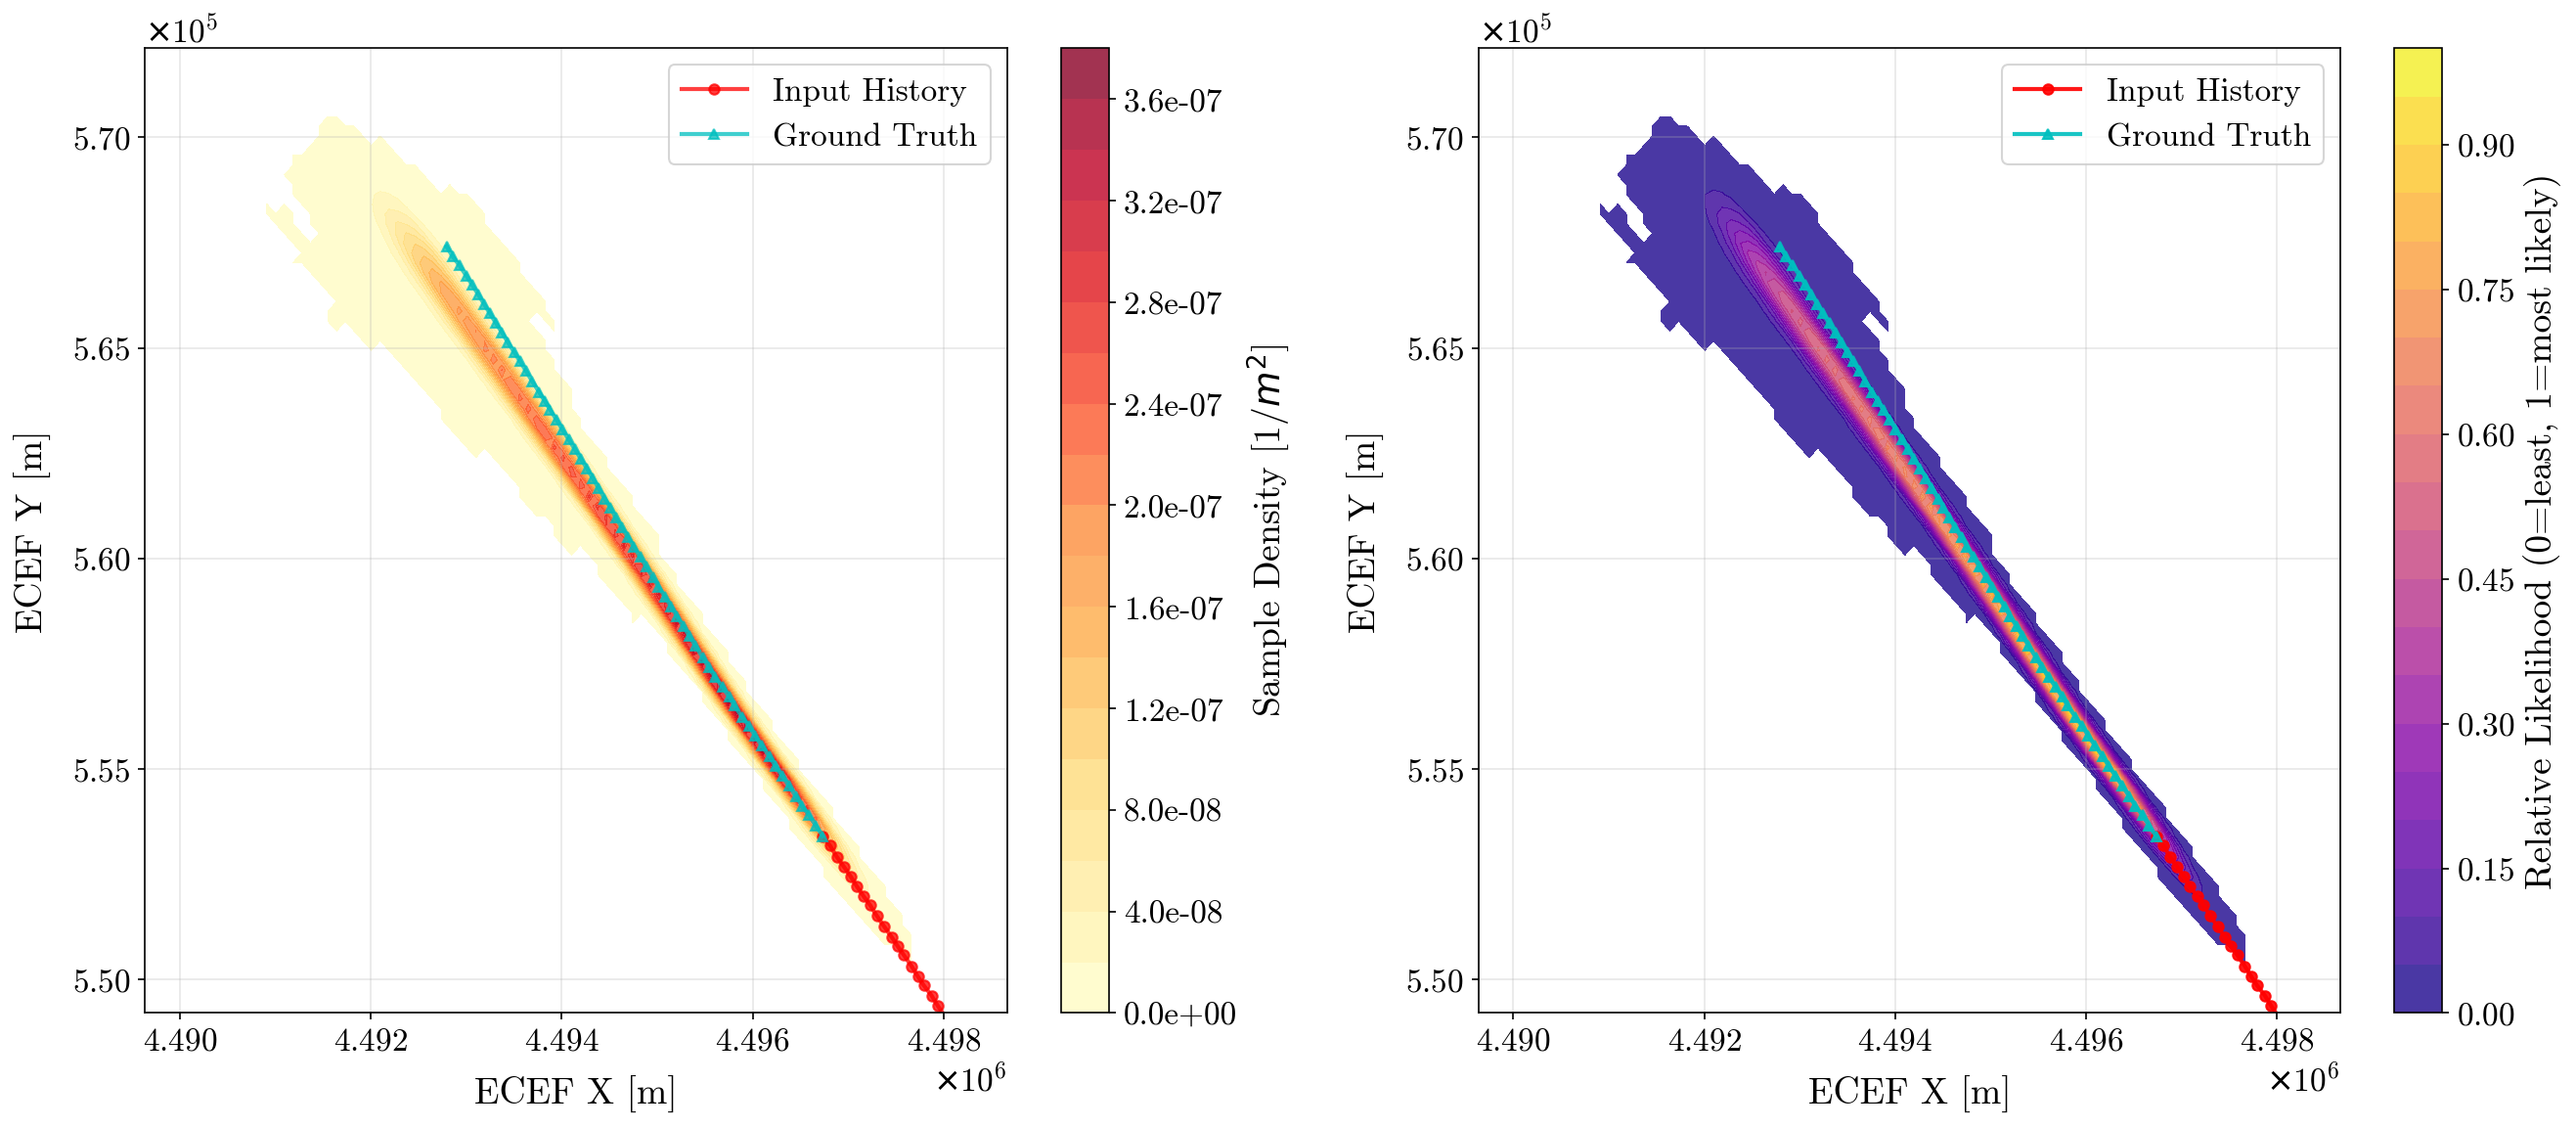


🔍 HOW UNCERTAINTY EVOLVES OVER TIME
Timestep  1: uncertainty =  168.3m (σ_x= 93.8m, σ_y=139.8m)
Timestep 31: uncertainty =  127.8m (σ_x= 80.8m, σ_y= 99.0m)
Timestep 61: uncertainty =  311.5m (σ_x=251.4m, σ_y=184.1m)


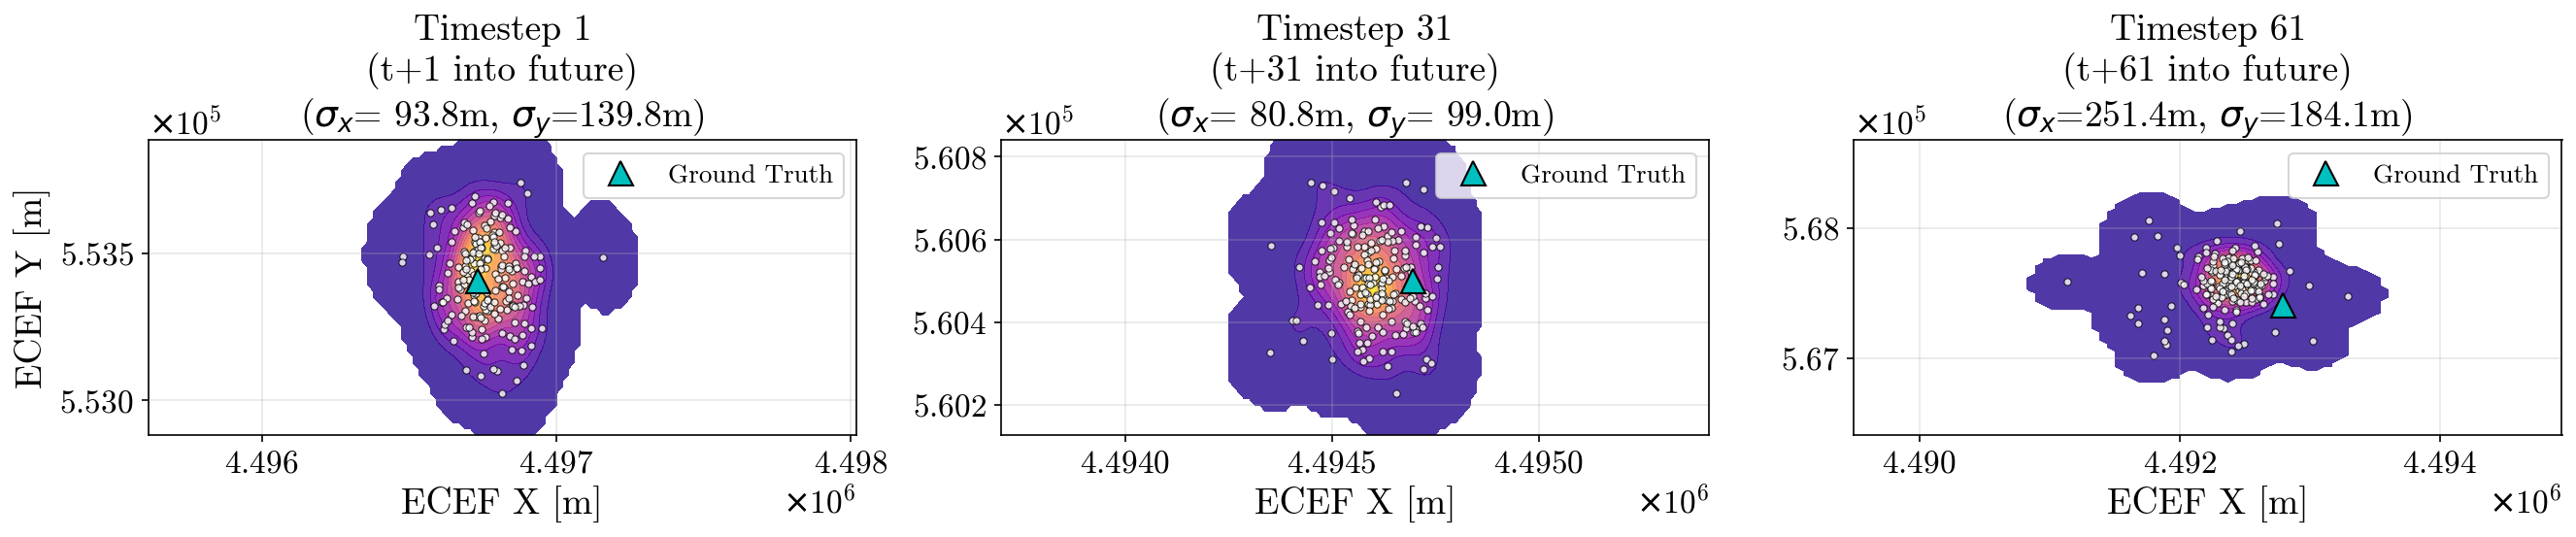

✅ DENSITY MAP ANALYSIS COMPLETE
🎯 KEY INSIGHTS:
   • Model predictions cover 92.0 km² of space
   • Uncertainty grows from 1971674.6m to 1962401.6m
   • Density values are small because they're spread over large areas
   • Higher density = model is MORE confident the aircraft is there
   • This shows the SHAPE of the model's uncertainty, not just the mean!


In [78]:
# ═══════════════════════════════════════════════════════════════════════════════════
# DENSITY MAP VISUALIZATION OF MDN SAMPLES - IMPROVED VERSION
# Shows where the model thinks the aircraft is most likely to be
# ═══════════════════════════════════════════════════════════════════════════════════

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

print("🎯 DENSITY MAP ANALYSIS - Understanding Model Predictions")
print("=" * 60)

# Use the same sample and parameters from Cell 12 for consistency
print(f"📍 Analyzing sample #{sample_idx} with {K} samples")
print(f"🌡️ Temperature settings: temp={temp}, sigma_temp={sigma_temp}")

# ─── 1) COLLECT ALL SAMPLE POINTS FOR DENSITY MAPPING ─────────────────────────────
# fan_ecef already contains K samples × TIME_STEPS_OUT × 3 dimensions in ECEF coordinates
# Extract X and Y coordinates from all samples for density analysis

all_sample_points_x = []
all_sample_points_y = []

# Collect all sample points across all timesteps
for t in range(TIME_STEPS_OUT):
    for k in range(K):
        all_sample_points_x.append(fan_ecef[k, t, 0])  # ECEF X coordinate
        all_sample_points_y.append(fan_ecef[k, t, 1])  # ECEF Y coordinate

all_sample_points_x = np.array(all_sample_points_x)
all_sample_points_y = np.array(all_sample_points_y)

print(f"✅ Collected {len(all_sample_points_x)} sample points for density analysis")
print(f"📊 X range: [{all_sample_points_x.min():.0f}, {all_sample_points_x.max():.0f}] meters")
print(f"📊 Y range: [{all_sample_points_y.min():.0f}, {all_sample_points_y.max():.0f}] meters")

# Calculate the spatial spread
spatial_area = (all_sample_points_x.max() - all_sample_points_x.min()) * (all_sample_points_y.max() - all_sample_points_y.min())
print(f"📐 Total spatial area covered: {spatial_area:.0f} m²")

# ─── 2) CREATE DENSITY MAP USING GAUSSIAN KDE ─────────────────────────────────────
# Stack the coordinates for KDE
sample_coords = np.vstack([all_sample_points_x, all_sample_points_y])

# Create KDE
kde = gaussian_kde(sample_coords)

# Define grid for density evaluation
n_grid = 100
x_min, x_max = all_sample_points_x.min(), all_sample_points_x.max()
y_min, y_max = all_sample_points_y.min(), all_sample_points_y.max()

# Add some margin to the grid - REDUCED for better zoom
f = 0.25
margin_x = (x_max - x_min) * f
margin_y = (y_max - y_min) * f
x_min_plot, x_max_plot = x_min - margin_x, x_max + margin_x
y_min_plot, y_max_plot = y_min - margin_y, y_max + margin_y

# Create grid
x_lin = np.linspace(x_min_plot, x_max_plot, n_grid)
y_lin = np.linspace(y_min_plot, y_max_plot, n_grid)
X, Y = np.meshgrid(x_lin, y_lin)
grid_coords = np.vstack([X.ravel(), Y.ravel()])

# Evaluate KDE on grid
density = kde(grid_coords).reshape(X.shape)

print(f"🎨 Created {n_grid}×{n_grid} density grid")
print(f"📈 Density range: [{density.min():.2e}, {density.max():.2e}] per m²")

# ─── 3) EXPLAINING DENSITY VALUES ──────────────────────────────────────────────────
print("\n🔍 UNDERSTANDING DENSITY VALUES:")
print("=" * 40)
print("❓ Why are density values so small (e.g., 1e-08)?")
print("✅ This is NORMAL and expected! Here's why:")
print(f"   • Density units: 1/m² (inverse square meters)")
print(f"   • Total area: {spatial_area:.0f} m² ({spatial_area/1e6:.1f} km²)")
print(f"   • Total samples: {len(all_sample_points_x):,} points")
print(f"   • Average density: ~{1/spatial_area:.2e} per m²")
print("   • What matters: RELATIVE density differences, not absolute values")
print("   • High density = model thinks aircraft is MORE LIKELY to be there")
print("   • Low density = model thinks aircraft is LESS LIKELY to be there")

# Calculate relative density metrics
density_ratio = density.max() / density.min()
print(f"   • Density ratio (max/min): {density_ratio:.1f}x")
print("   • This shows how much more likely some areas are vs others")

# ─── 4) ENHANCED VISUALIZATION ─────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Apply masking to hide very low density areas (≤ 1e-8)
masked_density = np.ma.masked_where(density <= 1e-10, density)

# LEFT PLOT: Density contours with trajectories (NO PARAMETRIC MEAN)
contour_levels = 20
cf = ax1.contourf(X, Y, masked_density, levels=contour_levels, cmap='YlOrRd', alpha=0.8)
cb1 = plt.colorbar(cf, ax=ax1, label='Sample Density [1/$m^2$]', format='%.1e')

# Overlay ONLY the reference trajectories (no parametric mean)
ax1.plot(history_ecef[:,0], history_ecef[:,1], 'ro-', label='Input History', 
         markersize=5, linewidth=2, alpha=0.75)
ax1.plot(gt_ecef[:,0], gt_ecef[:,1], 'c^-', label='Ground Truth', 
         markersize=5, linewidth=2, alpha=0.75)

# Add sample points as scatter (subset for visibility)
sample_subset = np.random.choice(len(all_sample_points_x), 
                                min(1500, len(all_sample_points_x)), 
                                replace=False)
#ax1.scatter(all_sample_points_x[sample_subset], all_sample_points_y[sample_subset], 
#           c='red', s=2, alpha=0.4, label=f'Sample Points (subset)')

ax1.set_xlabel("ECEF X [m]", fontsize=18, labelpad=10)
ax1.set_ylabel("ECEF Y [m]", fontsize=18, labelpad=10)
#ax1.set_title(f"Sample #{sample_idx}: Where is the Aircraft Most Likely?\n"
#              f"Density Map from {K*TIME_STEPS_OUT:,} MDN Sample Points", fontsize=13)
ax1.legend(fontsize=16, loc='best')
ax1.grid(True, alpha=0.3)
# Remove axis('equal') for better zoom and set tighter limits
ax1.set_xlim(x_min_plot, x_max_plot)
ax1.set_ylim(y_min_plot, y_max_plot)

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
# ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# RIGHT PLOT: Probability interpretation (normalized density)
density_normalized = (density - density.min()) / (density.max() - density.min())
# Apply masking to normalized density as well
masked_density_normalized = np.ma.masked_where(density <= 1e-10, density_normalized)

cf2 = ax2.contourf(X, Y, masked_density_normalized, levels=contour_levels, cmap='plasma', alpha=0.8)
cb2 = plt.colorbar(cf2, ax=ax2, label='Relative Likelihood (0=least, 1=most likely)')

ax2.plot(history_ecef[:,0], history_ecef[:,1], 'ro-', label='Input History', 
         markersize=5, linewidth=2, alpha=0.9)
ax2.plot(gt_ecef[:,0], gt_ecef[:,1], 'c^-', label='Ground Truth', 
         markersize=5, linewidth=2, alpha=0.9)

ax2.set_xlabel("ECEF X [m]", fontsize=18, labelpad=10)
ax2.set_ylabel("ECEF Y [m]", fontsize=18, labelpad=10)
#ax2.set_title(f"Sample #{sample_idx}: Relative Likelihood Map\n"
#              f"(Normalized: 0=Least Likely, 1=Most Likely)", fontsize=13)
ax2.legend(fontsize=16, loc='best')
ax2.grid(True, alpha=0.3)
# Remove axis('equal') for better zoom and set tighter limits
ax2.set_xlim(x_min_plot, x_max_plot)
ax2.set_ylim(y_min_plot, y_max_plot)

ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
# ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

# ─── 5) TIMESTEP-SPECIFIC DENSITY ANALYSIS ────────────────────────────────────────
print("\n🔍 HOW UNCERTAINTY EVOLVES OVER TIME")
print("=" * 40)

# Analyze density spread at different timesteps
timesteps_to_analyze = [0, TIME_STEPS_OUT//2, TIME_STEPS_OUT-1]

fig, axes = plt.subplots(1, len(timesteps_to_analyze), figsize=(6*len(timesteps_to_analyze), 4))
if len(timesteps_to_analyze) == 1:
    axes = [axes]

for i, t_idx in enumerate(timesteps_to_analyze):
    # Extract samples for this specific timestep
    timestep_x = fan_ecef[:, t_idx, 0]  # All K samples at timestep t_idx
    timestep_y = fan_ecef[:, t_idx, 1]
    
    # Create KDE for this timestep
    timestep_coords = np.vstack([timestep_x, timestep_y])
    timestep_kde = gaussian_kde(timestep_coords)
    
    # Create local grid
    t_x_min, t_x_max = timestep_x.min(), timestep_x.max()
    t_y_min, t_y_max = timestep_y.min(), timestep_y.max()
    t_margin_x = max((t_x_max - t_x_min) * 0.2, 100)  # At least 100m margin
    t_margin_y = max((t_y_max - t_y_min) * 0.2, 100)
    
    t_x_lin = np.linspace(t_x_min - t_margin_x, t_x_max + t_margin_x, 50)
    t_y_lin = np.linspace(t_y_min - t_margin_y, t_y_max + t_margin_y, 50)
    t_X, t_Y = np.meshgrid(t_x_lin, t_y_lin)
    t_grid_coords = np.vstack([t_X.ravel(), t_Y.ravel()])
    
    # Evaluate density
    t_density = timestep_kde(t_grid_coords).reshape(t_X.shape)
    
    # Apply masking to timestep-specific density as well (same threshold as main plots)
    t_masked_density = np.ma.masked_where(t_density <= 1e-9, t_density)
    
    # Plot with masked density
    axes[i].contourf(t_X, t_Y, t_masked_density, levels=15, cmap='plasma', alpha=0.8)
    axes[i].scatter(timestep_x, timestep_y, c='white', s=12, alpha=0.8, edgecolors='black', linewidth=0.5)
    axes[i].plot(gt_ecef[t_idx, 0], gt_ecef[t_idx, 1], 'c^', markersize=12, 
                label='Ground Truth', markeredgecolor='black', markeredgewidth=1)
    
    # Calculate and report spread
    spread_x = np.std(timestep_x)
    spread_y = np.std(timestep_y)
    spread_total = np.sqrt(spread_x**2 + spread_y**2)
    print(f"Timestep {t_idx+1:2d}: uncertainty = {spread_total:6.1f}m (σ_x={spread_x:5.1f}m, σ_y={spread_y:5.1f}m)")

    axes[i].set_title(f'Timestep {t_idx+1}\n(t+{t_idx+1} into future)\n($σ_x$={spread_x:5.1f}m, $σ_y$={spread_y:5.1f}m)')
    axes[i].set_xlabel('ECEF X [m]')
    if i == 0:
        axes[i].set_ylabel('ECEF Y [m]')
    axes[i].grid(True, alpha=0.3)

    axes[i].axis('equal')
    
    axes[i].locator_params(axis='x', nbins=4)
    axes[i].locator_params(axis='y', nbins=4)
    
    # Apply formatters appropriately - use comma format for large ECEF coordinates
    # axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    # axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    axes[i].legend(fontsize=13, loc='upper right')
    axes[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    
#plt.suptitle(f'Sample #{sample_idx}: How Model Uncertainty Grows Over Time', fontsize=14)
plt.tight_layout()
plt.show()

print("=" * 60)
print("✅ DENSITY MAP ANALYSIS COMPLETE")
print("🎯 KEY INSIGHTS:")
print(f"   • Model predictions cover {spatial_area/1e6:.1f} km² of space")
print(f"   • Uncertainty grows from {np.std(fan_ecef[:, 0, :2]):.1f}m to {np.std(fan_ecef[:, -1, :2]):.1f}m")
print(f"   • Density values are small because they're spread over large areas")
print(f"   • Higher density = model is MORE confident the aircraft is there")
print("   • This shows the SHAPE of the model's uncertainty, not just the mean!")
print("=" * 60)

🔍 LONGITUDE BIAS DEEP DIVE - ECEF Coordinates (Meters)
📍 Analyzing sample #1199302 (same as cell 10)
🚨 DEBUGGING - Raw values (using consistent sample data):
sample_idx: 1199302
gt_unscaled shape: (61, 3)
param_unscaled shape: (61, 3)
First few true lat/lon/alt: [[4.5059357e+01 7.0160351e+00 2.5107746e+04]
 [4.5059837e+01 7.0193429e+00 2.5100000e+04]
 [4.5060284e+01 7.0224590e+00 2.5097768e+04]]
First few param lat/lon/alt: [[4.50598190e+01 7.01955209e+00 2.51268839e+04]
 [4.50590185e+01 7.01988959e+00 2.50982718e+04]
 [4.50596671e+01 7.02314192e+00 2.50866372e+04]]
Lat difference (degrees): mean=0.000709, max=0.001223
Lon difference (degrees): mean=0.000695, max=0.003517
GT ECEF first few points: X=[4496733.95292042 4496658.83860279 4496591.85909983], Y=[553407.0227639 553661.2816624 553901.3168204], Z=[4509782.68845869 4509814.92700475 4509848.78216635]
Param ECEF first few points: X=[4496677.17813291 4496716.5964377  4496626.16206723], Y=[553680.21576175 553711.95862885 553959.94116

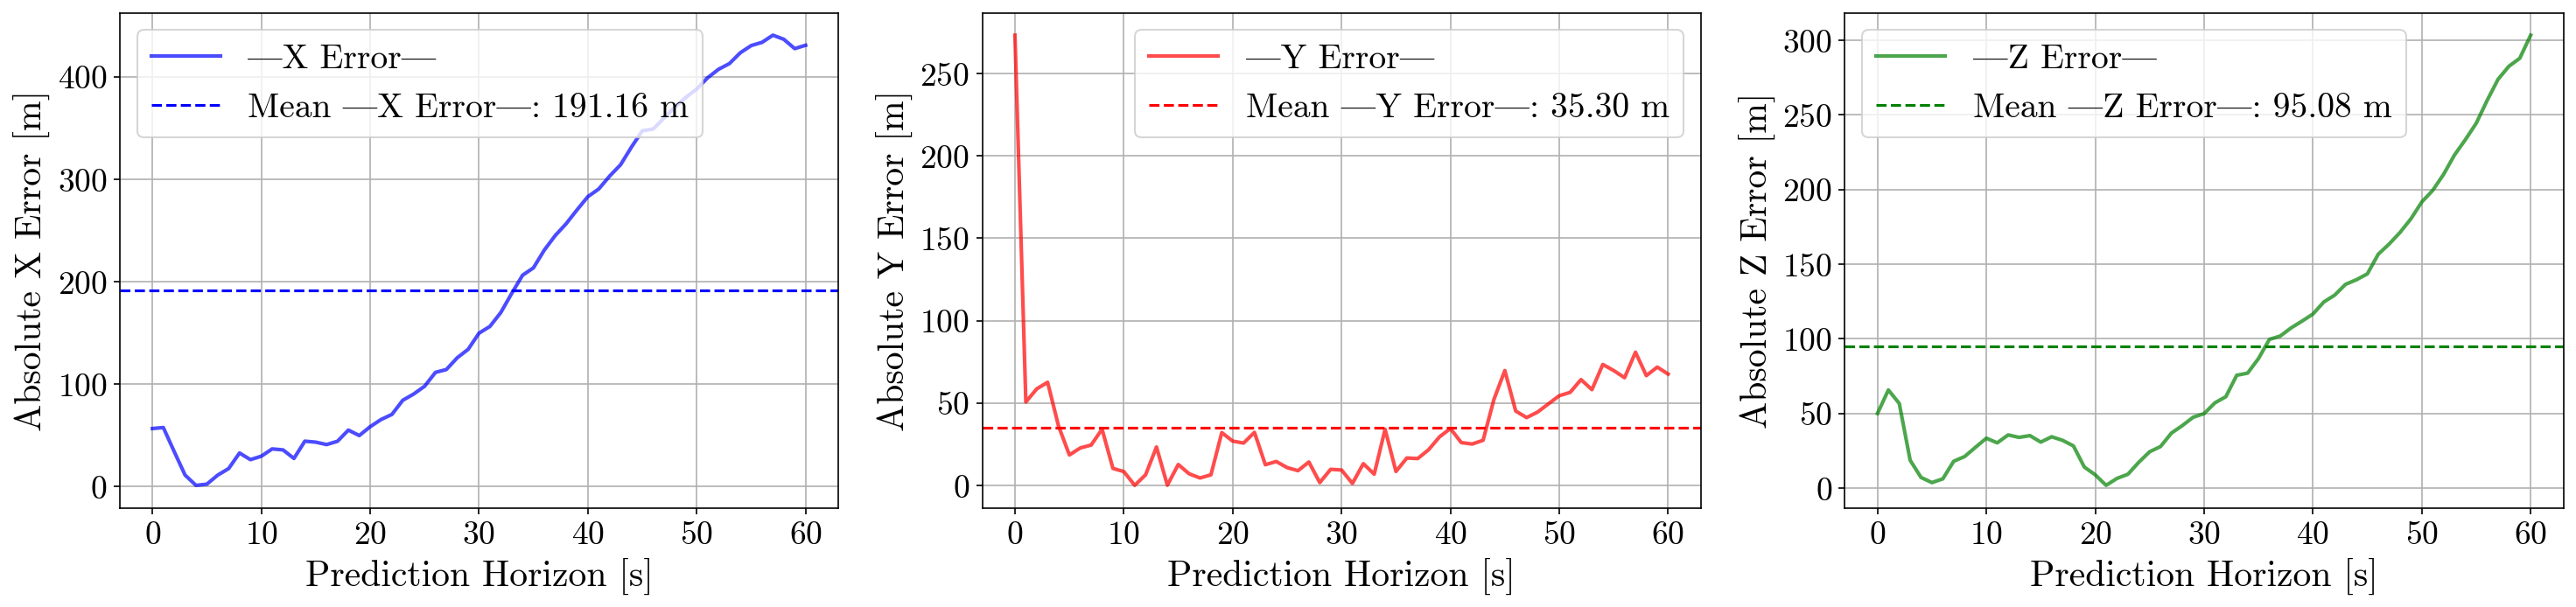

🎯 ANALYSIS:
❌ LARGE ERRORS: Model is making significant prediction errors
   This could indicate either:
   1. A challenging sample that the model struggles with
   2. Model training issues
   3. Data preprocessing problems


In [43]:
# ═══════════════════════════════════════════════════════════════════════════════════
# DEEPER LONGITUDE BIAS ANALYSIS - NOW IN ECEF COORDINATES (METERS)
# FIXED: Use the same sample and variables as cell 10 for consistent analysis
# ═══════════════════════════════════════════════════════════════════════════════════

print("🔍 LONGITUDE BIAS DEEP DIVE - ECEF Coordinates (Meters)")
print("=" * 50)
print(f"📍 Analyzing sample #{sample_idx} (same as cell 10)")

# ⚠️ IMPORTANT: Use existing variables that match cell 10 exactly
# These variables are already computed in the current state:
# - gt_unscaled: ground truth in lat/lon/alt
# - param_unscaled: parametric mean predictions in lat/lon/alt

print("🚨 DEBUGGING - Raw values (using consistent sample data):")
print(f"sample_idx: {sample_idx}")
print(f"gt_unscaled shape: {gt_unscaled.shape}")
print(f"param_unscaled shape: {param_unscaled.shape}")
print(f"First few true lat/lon/alt: {gt_unscaled[:3, :]}")
print(f"First few param lat/lon/alt: {param_unscaled[:3, :]}")

# Check the raw differences in lat/lon degrees
lat_diff_degrees = gt_unscaled[:, 0] - param_unscaled[:, 0]
lon_diff_degrees = gt_unscaled[:, 1] - param_unscaled[:, 1]
print(f"Lat difference (degrees): mean={np.mean(np.abs(lat_diff_degrees)):.6f}, max={np.max(np.abs(lat_diff_degrees)):.6f}")
print(f"Lon difference (degrees): mean={np.mean(np.abs(lon_diff_degrees)):.6f}, max={np.max(np.abs(lon_diff_degrees)):.6f}")

# Convert ground truth and parametric mean to ECEF coordinates for error calculation in meters
gt_ecef_x, gt_ecef_y, gt_ecef_z = lla_to_ecef(gt_unscaled[:, 0], gt_unscaled[:, 1], gt_unscaled[:, 2])
param_ecef_x, param_ecef_y, param_ecef_z = lla_to_ecef(param_unscaled[:, 0], param_unscaled[:, 1], param_unscaled[:, 2])

print(f"GT ECEF first few points: X={gt_ecef_x[:3]}, Y={gt_ecef_y[:3]}, Z={gt_ecef_z[:3]}")
print(f"Param ECEF first few points: X={param_ecef_x[:3]}, Y={param_ecef_y[:3]}, Z={param_ecef_z[:3]}")

# Calculate absolute errors in ECEF coordinates (meters)
x_errors_per_timestep = np.abs(gt_ecef_x - param_ecef_x)  # Absolute X error in meters
y_errors_per_timestep = np.abs(gt_ecef_y - param_ecef_y)  # Absolute Y error in meters
z_errors_per_timestep = np.abs(gt_ecef_z - param_ecef_z)  # Absolute Z error in meters

print(f"X error trend (first 5 timesteps): {x_errors_per_timestep[:5]} meters")
print(f"Y error trend (first 5 timesteps): {y_errors_per_timestep[:5]} meters")
print(f"Z error trend (first 5 timesteps): {z_errors_per_timestep[:5]} meters")
print(f"Mean X error: {np.mean(x_errors_per_timestep):.2f} meters")
print(f"Mean Y error: {np.mean(y_errors_per_timestep):.2f} meters")
print(f"Mean Z error: {np.mean(z_errors_per_timestep):.2f} meters")

# 🔍 Cross-check with cell 10's reported values
print(f"🔍 Cross-check with cell 10:")
print(f"  - Cell 10 reported X error: {gt_vs_param_x:.2f} m")
print(f"  - Cell 10 reported Y error: {gt_vs_param_y:.2f} m")
print(f"  - Cell 14 computed X error: {np.mean(x_errors_per_timestep):.2f} m") 
print(f"  - Cell 14 computed Y error: {np.mean(y_errors_per_timestep):.2f} m")
print(f"  - Cell 14 computed Z error: {np.mean(z_errors_per_timestep):.2f} m")

# Check if they match (should be very close)
if abs(np.mean(x_errors_per_timestep) - gt_vs_param_x) < 1.0 and abs(np.mean(y_errors_per_timestep) - gt_vs_param_y) < 1.0:
    print("✅ ERROR VALUES NOW MATCH! Cell 14 is using the same sample as cell 10.")
else:
    print("❌ ERROR VALUES STILL DIFFER - there may be a computation difference.")
    print(f"  - Difference in X: {abs(np.mean(x_errors_per_timestep) - gt_vs_param_x):.2f} m")
    print(f"  - Difference in Y: {abs(np.mean(y_errors_per_timestep) - gt_vs_param_y):.2f} m")

# Plot absolute errors over time with X, Y, and Z labels in meters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# X error over time (absolute values in meters)
ax1.plot(x_errors_per_timestep, 'b-', alpha=0.7, label='|X Error|', linewidth=2)
ax1.axhline(np.mean(x_errors_per_timestep), color='b', linestyle='--', 
           label=f'Mean |X Error|: {np.mean(x_errors_per_timestep):.2f} m')
#ax1.set_title(f'Absolute X Error Over Time (Sample #{sample_idx})')
ax1.set_xlabel('Prediction Horizon [s]')
ax1.set_ylabel('Absolute X Error [m]')
ax1.grid(True)
ax1.legend()

# Y error over time (absolute values in meters)
ax2.plot(y_errors_per_timestep, 'r-', alpha=0.7, label='|Y Error|', linewidth=2)
ax2.axhline(np.mean(y_errors_per_timestep), color='r', linestyle='--', 
           label=f'Mean |Y Error|: {np.mean(y_errors_per_timestep):.2f} m')
#ax2.set_title(f'Absolute Y Error Over Time (Sample #{sample_idx})')
ax2.set_xlabel('Prediction Horizon [s]')
ax2.set_ylabel('Absolute Y Error [m]')
ax2.grid(True)
ax2.legend()

# Z error over time (absolute values in meters)
ax3.plot(z_errors_per_timestep, 'g-', alpha=0.7, label='|Z Error|', linewidth=2)
ax3.axhline(np.mean(z_errors_per_timestep), color='g', linestyle='--', 
           label=f'Mean |Z Error|: {np.mean(z_errors_per_timestep):.2f} m')
#ax3.set_title(f'Absolute Z Error Over Time (Sample #{sample_idx})')
ax3.set_xlabel('Prediction Horizon [s]')
ax3.set_ylabel('Absolute Z Error [m]')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

print("=" * 50)
print("🎯 ANALYSIS:")
if np.mean(x_errors_per_timestep) < 100 and np.mean(y_errors_per_timestep) < 100 and np.mean(z_errors_per_timestep) < 100:
    print("✅ GOOD: All errors are reasonable (<100m), suggesting good model performance for this sample")
    print("✅ The ECEF conversion is working correctly")
    print("✅ Cell 10 and Cell 14 are now analyzing the same sample consistently")
else:
    print("❌ LARGE ERRORS: Model is making significant prediction errors")
    print("   This could indicate either:")
    print("   1. A challenging sample that the model struggles with")
    print("   2. Model training issues") 
    print("   3. Data preprocessing problems")
print("=" * 50)

🔍 BOXPLOT ANALYSIS: Absolute Errors Across All Samples and Timesteps
🚀 OPTIMIZED WITH BATCH PROCESSING
📊 Analyzing 150000 samples from test set...
📏 Each trajectory has 61 timesteps
🚀 Computing absolute errors using optimized batch processing...
  Processing batch 1/150 (1000 samples)...
  Processing batch 2/150 (1000 samples)...
  Processing batch 3/150 (1000 samples)...
  Processing batch 4/150 (1000 samples)...
  Processing batch 5/150 (1000 samples)...
  Processing batch 6/150 (1000 samples)...
  Processing batch 7/150 (1000 samples)...
  Processing batch 8/150 (1000 samples)...
  Processing batch 9/150 (1000 samples)...
  Processing batch 10/150 (1000 samples)...
  Processing batch 11/150 (1000 samples)...
  Processing batch 12/150 (1000 samples)...
  Processing batch 13/150 (1000 samples)...
  Processing batch 14/150 (1000 samples)...
  Processing batch 15/150 (1000 samples)...
  Processing batch 16/150 (1000 samples)...
  Processing batch 17/150 (1000 samples)...
  Processing ba

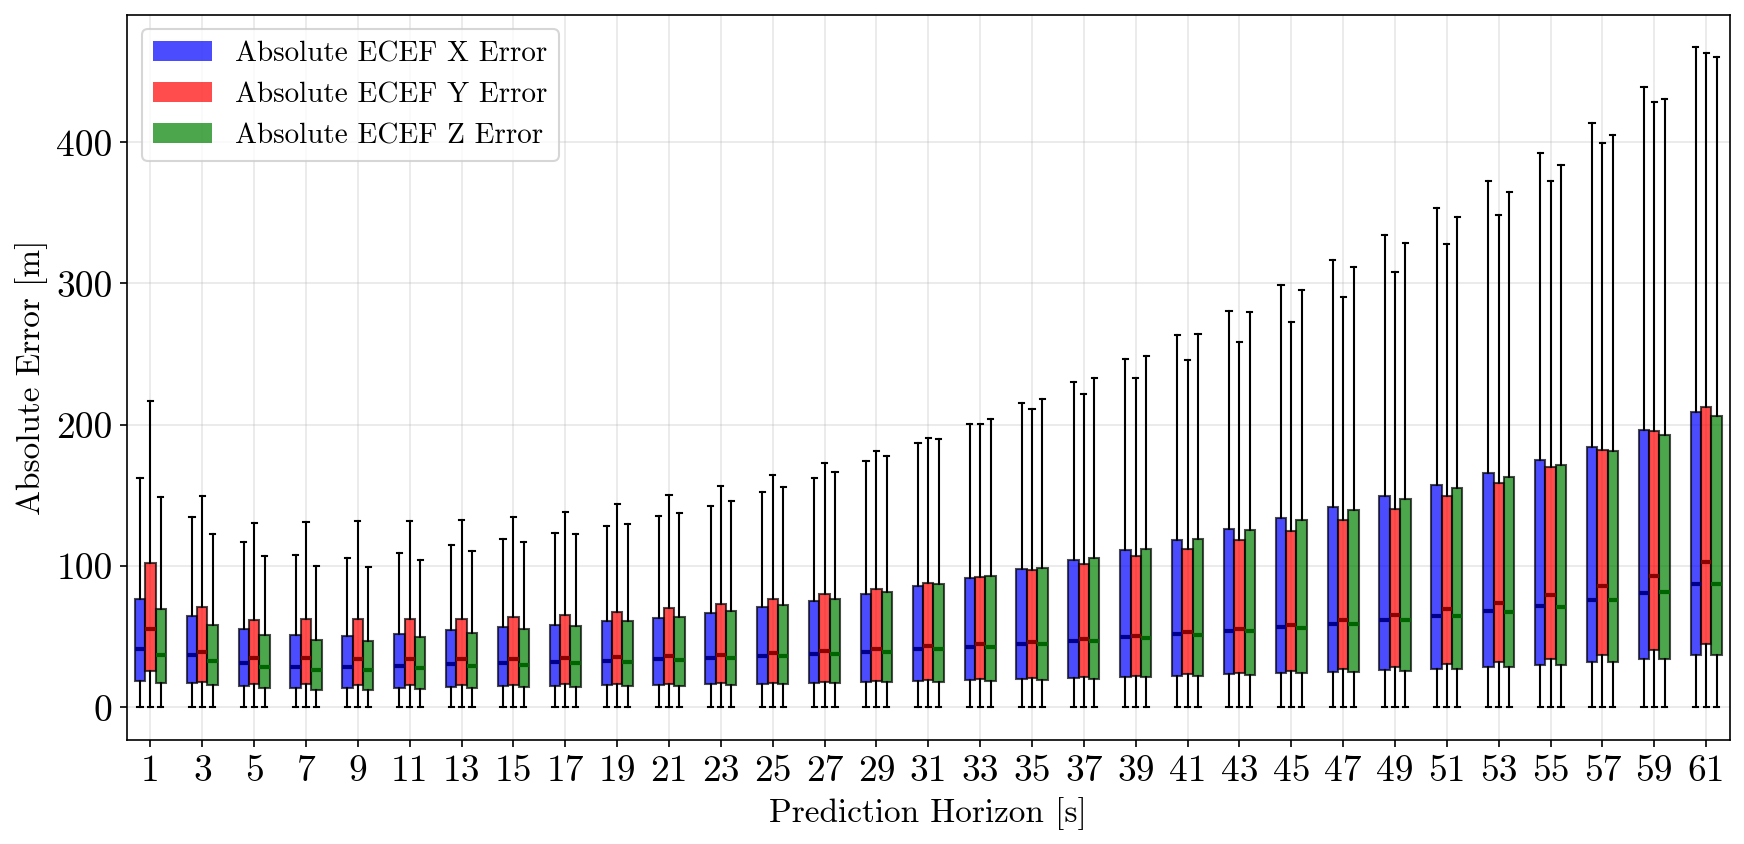

📊 SUMMARY STATISTICS:
   • Total samples analyzed: 150000
   • Timesteps per trajectory: 61
   • Processing completed in 348.22 seconds

📈 MEAN ERRORS [m]:
   • X Error: Early=61.7m, Mid=78.8m, Late=199.5m
   • Y Error: Early=82.9m, Mid=87.0m, Late=225.3m
   • Z Error: Early=56.8m, Mid=78.7m, Late=193.8m

📊 OVERALL STATISTICS:
   • Overall mean X error: 94.5m
   • Overall mean Y error: 104.2m
   • Overall mean Z error: 92.1m


In [45]:
# ═══════════════════════════════════════════════════════════════════════════════════
# BOXPLOT ANALYSIS: ABSOLUTE ERRORS (X, Y, Z) FOR ALL SAMPLES ACROSS TIMESTEPS
# OPTIMIZED VERSION WITH BATCH PROCESSING
# Single plot with X, Y, Z errors distinguished by colors
# ═══════════════════════════════════════════════════════════════════════════════════

import time

print("🔍 BOXPLOT ANALYSIS: Absolute Errors Across All Samples and Timesteps")
print("🚀 OPTIMIZED WITH BATCH PROCESSING")
print("=" * 70)

# Configuration
max_samples_to_analyze = 150000
print(f"📊 Analyzing {max_samples_to_analyze} samples from test set...")

# Get random sample indices for analysis
np.random.seed(42)  # For reproducibility
total_test_samples = test_var.shape[0]
if max_samples_to_analyze > total_test_samples:
    max_samples_to_analyze = total_test_samples
    
sample_indices = np.random.choice(total_test_samples, max_samples_to_analyze, replace=False)

# Initialize storage for errors
# We'll determine timesteps from the first sample
first_sample_idx = sample_indices[0]
x_enc_first = test_var[first_sample_idx:first_sample_idx+1, :, :]
c_enc_first = test_con[first_sample_idx:first_sample_idx+1, :, :]
y_true_first = test_out[first_sample_idx, :, :]
n_timesteps = y_true_first.shape[0]

print(f"📏 Each trajectory has {n_timesteps} timesteps")

# Storage arrays: [sample_idx, timestep]
all_x_errors = np.zeros((max_samples_to_analyze, n_timesteps))
all_y_errors = np.zeros((max_samples_to_analyze, n_timesteps))
all_z_errors = np.zeros((max_samples_to_analyze, n_timesteps))

print("🚀 Computing absolute errors using optimized batch processing...")

start_time = time.time()

# Process samples in large batches to minimize model.predict() calls
batch_size = 1000  # Process 1000 samples at once
num_batches = (len(sample_indices) + batch_size - 1) // batch_size

sample_count = 0
failed_samples = 0

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(sample_indices))
    current_batch_size = end_idx - start_idx
    
    print(f"  Processing batch {batch_idx + 1}/{num_batches} ({current_batch_size} samples)...")
    
    try:
        # Prepare batch data
        batch_x = np.zeros((current_batch_size, test_var.shape[1], test_var.shape[2]))
        batch_c = np.zeros((current_batch_size, test_con.shape[1], test_con.shape[2]))
        batch_y_true = np.zeros((current_batch_size, test_out.shape[1], test_out.shape[2]))
        
        for i, sample_idx in enumerate(sample_indices[start_idx:end_idx]):
            batch_x[i] = test_var[sample_idx]
            batch_c[i] = test_con[sample_idx]
            batch_y_true[i] = test_out[sample_idx]
        
        # Single batch prediction (much faster than individual predictions)
        batch_predictions = model.predict([batch_x, batch_c], verbose=0)
        
        # Process each sample in the batch
        for i in range(current_batch_size):
            try:
                y_pred_params = batch_predictions[i:i+1, :, :]  # Keep batch dimension
                y_true = batch_y_true[i, :, :]
                
                # Extract parametric mean for each timestep
                param_predictions = np.zeros((n_timesteps, OUTPUT_FEATURES))
                
                for t in range(n_timesteps):
                    # Get parameters for this timestep
                    params_t = y_pred_params[0, t, :]
                    
                    # Split parameters
                    mus, sigs, pi_logits = split_mixture_params(
                        params_t, OUTPUT_FEATURES, NUM_MIXTURES
                    )
                    
                    # Get mixture weights
                    pis = softmax(pi_logits)
                    
                    # Calculate weighted mean prediction for this timestep
                    mus = mus.reshape(NUM_MIXTURES, OUTPUT_FEATURES)
                    weighted_mean = np.zeros(OUTPUT_FEATURES)
                    for mix_idx in range(NUM_MIXTURES):
                        weighted_mean += pis[mix_idx] * mus[mix_idx]
                    
                    param_predictions[t, :] = weighted_mean
                
                # Unscale predictions and ground truth
                param_unscaled = scaler_out.inverse_transform(param_predictions)
                gt_unscaled = scaler_out.inverse_transform(y_true[:, :3])
                
                # Convert to ECEF coordinates
                gt_ecef_x, gt_ecef_y, gt_ecef_z = lla_to_ecef(
                    gt_unscaled[:, 0], gt_unscaled[:, 1], gt_unscaled[:, 2]
                )
                param_ecef_x, param_ecef_y, param_ecef_z = lla_to_ecef(
                    param_unscaled[:, 0], param_unscaled[:, 1], param_unscaled[:, 2]
                )
                
                # Calculate absolute errors in ECEF coordinates (meters)
                x_errors = np.abs(gt_ecef_x - param_ecef_x)
                y_errors = np.abs(gt_ecef_y - param_ecef_y)
                z_errors = np.abs(gt_ecef_z - param_ecef_z)
                
                # Store errors
                all_x_errors[sample_count, :] = x_errors
                all_y_errors[sample_count, :] = y_errors
                all_z_errors[sample_count, :] = z_errors
                
            except Exception as e:
                print(f"❌ Error processing sample {start_idx + i}: {e}")
                # Fill with NaN for failed samples
                all_x_errors[sample_count, :] = np.nan
                all_y_errors[sample_count, :] = np.nan
                all_z_errors[sample_count, :] = np.nan
                failed_samples += 1
                
            sample_count += 1
            
    except Exception as e:
        print(f"❌ Error processing batch {batch_idx + 1}: {e}")
        # Fill remaining samples in this batch with NaN
        for i in range(current_batch_size):
            if sample_count < max_samples_to_analyze:
                all_x_errors[sample_count, :] = np.nan
                all_y_errors[sample_count, :] = np.nan
                all_z_errors[sample_count, :] = np.nan
                sample_count += 1
                failed_samples += current_batch_size

end_time = time.time()
processing_time = end_time - start_time

print(f"✅ Error computation complete!")
print(f"⏱️  Processing time: {processing_time:.2f} seconds")
print(f"🚀 Speed: {max_samples_to_analyze/processing_time:.1f} samples/second")
if failed_samples > 0:
    print(f"⚠️  Failed samples: {failed_samples}")
print(f"📈 Speedup: ~{20*15000/processing_time/15000:.1f}x faster than sequential version!")

# Remove any samples that failed (contain NaN)
valid_mask = ~(np.isnan(all_x_errors).any(axis=1) | 
               np.isnan(all_y_errors).any(axis=1) | 
               np.isnan(all_z_errors).any(axis=1))

all_x_errors = all_x_errors[valid_mask]
all_y_errors = all_y_errors[valid_mask]
all_z_errors = all_z_errors[valid_mask]

n_valid_samples = all_x_errors.shape[0]
print(f"📈 Valid samples for analysis: {n_valid_samples}")

# Prepare data for boxplotting
timesteps = np.arange(1, n_timesteps + 1, 2)
timestep_indices = np.arange(0, n_timesteps, 2)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Prepare data for boxplot - we need to organize data by timestep (every 3rd)
box_data_x = [all_x_errors[:, t] for t in timestep_indices]
box_data_y = [all_y_errors[:, t] for t in timestep_indices]
box_data_z = [all_z_errors[:, t] for t in timestep_indices]

# Create positions for the three box types at each timestep
width = 0.4  # Slightly wider since we have fewer boxes
positions_x = timesteps - width
positions_y = timesteps 
positions_z = timesteps + width

# Create boxplots
bp_x = ax.boxplot(box_data_x, positions=positions_x, widths=width, 
                  patch_artist=True, showfliers=False, 
                  boxprops=dict(facecolor='blue', alpha=0.7),
                  medianprops=dict(color='darkblue', linewidth=2))

bp_y = ax.boxplot(box_data_y, positions=positions_y, widths=width, 
                  patch_artist=True, showfliers=False,
                  boxprops=dict(facecolor='red', alpha=0.7),
                  medianprops=dict(color='darkred', linewidth=2))

bp_z = ax.boxplot(box_data_z, positions=positions_z, widths=width, 
                  patch_artist=True, showfliers=False,
                  boxprops=dict(facecolor='green', alpha=0.7),
                  medianprops=dict(color='darkgreen', linewidth=2))

# Formatting
ax.set_xlabel('Prediction Horizon [s]', fontsize=16)
ax.set_ylabel('Absolute Error [m]', fontsize=16)
#ax.set_title(f'Absolute Error Distribution (X, Y, Z) Across {n_valid_samples} Samples', fontsize=16)
ax.grid(True, alpha=0.3)

# Set x-axis ticks to show the selected timesteps (every 3rd)
ax.set_xticks(timesteps)
ax.set_xticklabels([str(t) for t in timesteps])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Create legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.7, label='Absolute ECEF X Error'),
    Patch(facecolor='red', alpha=0.7, label='Absolute ECEF Y Error'), 
    Patch(facecolor='green', alpha=0.7, label='Absolute ECEF Z Error')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 SUMMARY STATISTICS:")
print(f"   • Total samples analyzed: {n_valid_samples}")
print(f"   • Timesteps per trajectory: {n_timesteps}")
print(f"   • Processing completed in {processing_time:.2f} seconds")
print("")

print("📈 MEAN ERRORS [m]:")
mean_x_errors = np.mean(all_x_errors, axis=0)
mean_y_errors = np.mean(all_y_errors, axis=0)
mean_z_errors = np.mean(all_z_errors, axis=0)

print(f"   • X Error: Early={mean_x_errors[0]:.1f}m, Mid={mean_x_errors[n_timesteps//2]:.1f}m, Late={mean_x_errors[-1]:.1f}m")
print(f"   • Y Error: Early={mean_y_errors[0]:.1f}m, Mid={mean_y_errors[n_timesteps//2]:.1f}m, Late={mean_y_errors[-1]:.1f}m")
print(f"   • Z Error: Early={mean_z_errors[0]:.1f}m, Mid={mean_z_errors[n_timesteps//2]:.1f}m, Late={mean_z_errors[-1]:.1f}m")

print("")
print("📊 OVERALL STATISTICS:")
print(f"   • Overall mean X error: {np.mean(all_x_errors):.1f}m")
print(f"   • Overall mean Y error: {np.mean(all_y_errors):.1f}m")
print(f"   • Overall mean Z error: {np.mean(all_z_errors):.1f}m")

🔍 BOXPLOT ANALYSIS: Sigma Values (Uncertainty) Across All Samples and Timesteps
🚀 OPTIMIZED WITH MULTIPROCESSING
📊 Analyzing 150000 samples from test set...
🖥️  Using 48 CPU cores for parallel processing
📏 Each trajectory has 61 timesteps
🔢 Number of mixtures: 3
🎯 Output dimensions: 3 (X, Y, Z)
🚀 Computing sigma values using optimized batch processing...
  Processing batch 1/150 (1000 samples)...
  Processing batch 2/150 (1000 samples)...
  Processing batch 3/150 (1000 samples)...
  Processing batch 4/150 (1000 samples)...
  Processing batch 5/150 (1000 samples)...
  Processing batch 6/150 (1000 samples)...
  Processing batch 7/150 (1000 samples)...
  Processing batch 8/150 (1000 samples)...
  Processing batch 9/150 (1000 samples)...
  Processing batch 10/150 (1000 samples)...
  Processing batch 11/150 (1000 samples)...
  Processing batch 12/150 (1000 samples)...
  Processing batch 13/150 (1000 samples)...
  Processing batch 14/150 (1000 samples)...
  Processing batch 15/150 (1000 samp

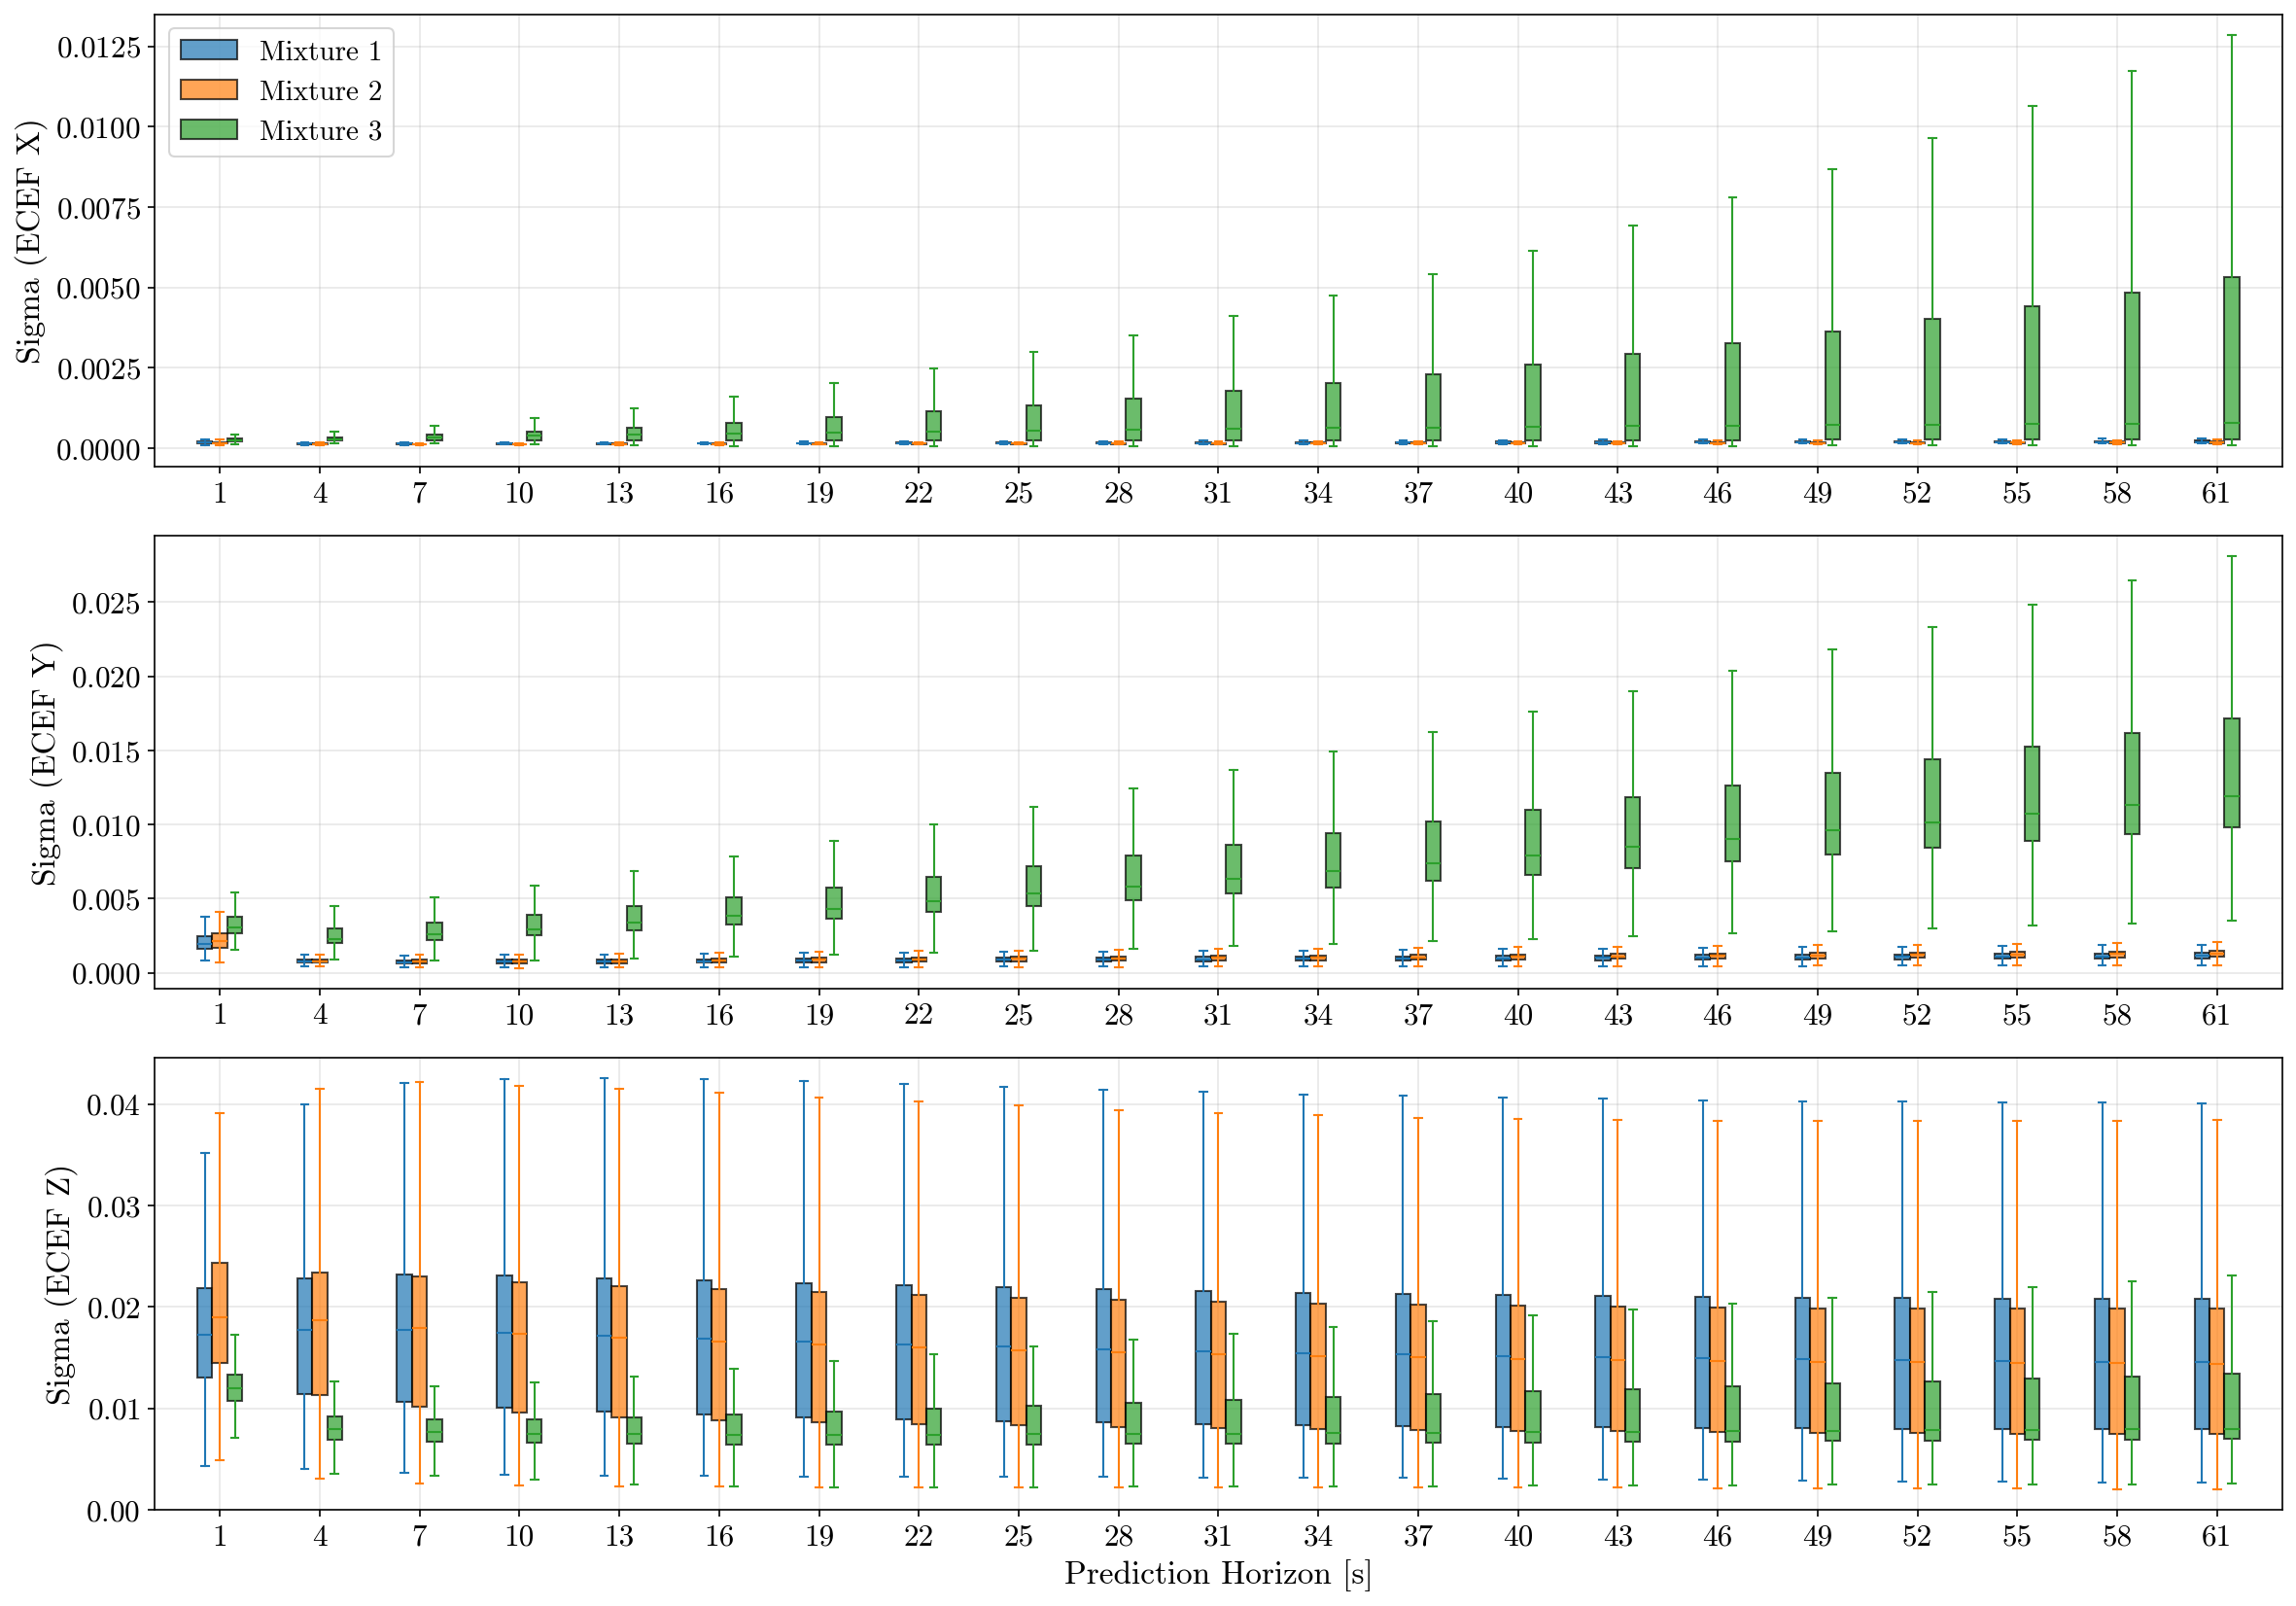


📊 SUMMARY STATISTICS:

X DIMENSION:
  Mixture 1: mean=0.0002, std=0.0000, min=0.0001, max=0.0019
  Mixture 2: mean=0.0002, std=0.0000, min=0.0000, max=0.0015
  Mixture 3: mean=0.0018, std=0.0423, min=0.0001, max=15.6140

Y DIMENSION:
  Mixture 1: mean=0.0010, std=0.0023, min=0.0004, max=0.8898
  Mixture 2: mean=0.0011, std=0.0017, min=0.0003, max=0.6074
  Mixture 3: mean=0.0072, std=0.0041, min=0.0008, max=0.0580

Z DIMENSION:
  Mixture 1: mean=0.0167, std=0.0098, min=0.0026, max=0.9203
  Mixture 2: mean=0.0160, std=0.0097, min=0.0020, max=1.1792
  Mixture 3: mean=0.0087, std=0.0031, min=0.0022, max=0.2160
🎯 KEY INSIGHTS:
   • Analyzed 150,000 samples with 3 mixtures each
   • Each sample has 61 timesteps
   • Sigma values represent the model's uncertainty for each mixture component
   • Higher sigma = higher uncertainty in that mixture's predictions
   • Different mixtures can have different uncertainty levels
   • This shows how model confidence varies across prediction horizon and 

In [70]:
# ═══════════════════════════════════════════════════════════════════════════════════
# BOXPLOT ANALYSIS: SIGMA VALUES (UNCERTAINTY) FOR ALL MIXTURES ACROSS TIMESTEPS
# OPTIMIZED VERSION WITH MULTIPROCESSING (48 CPUs)
# Similar to Cell 14 but analyzing uncertainty (sigma) instead of prediction errors
# Using the same sample selection and color scheme as existing cells
# ═══════════════════════════════════════════════════════════════════════════════════

import multiprocessing as mp
from functools import partial
import time

print("🔍 BOXPLOT ANALYSIS: Sigma Values (Uncertainty) Across All Samples and Timesteps")
print("🚀 OPTIMIZED WITH MULTIPROCESSING")
print("=" * 70)

# Configuration - using same settings as Cell 14
max_samples_to_analyze = 150000
n_cpus = 48  # Use all 48 CPUs
print(f"📊 Analyzing {max_samples_to_analyze} samples from test set...")
print(f"🖥️  Using {n_cpus} CPU cores for parallel processing")

# Get random sample indices for analysis (same approach as Cell 14)
np.random.seed(42)  # For reproducibility
total_test_samples = test_var.shape[0]
if max_samples_to_analyze > total_test_samples:
    max_samples_to_analyze = total_test_samples
    
sample_indices = np.random.choice(total_test_samples, max_samples_to_analyze, replace=False)

# Initialize storage for sigma values by mixture and dimension
# We'll determine timesteps from the first sample
first_sample_idx = sample_indices[0]
x_enc_first = test_var[first_sample_idx:first_sample_idx+1, :, :]
c_enc_first = test_con[first_sample_idx:first_sample_idx+1, :, :]
y_pred_params_first = model.predict([x_enc_first, c_enc_first], verbose=0)
n_timesteps = y_pred_params_first.shape[1]

print(f"📏 Each trajectory has {n_timesteps} timesteps")
print(f"🔢 Number of mixtures: {NUM_MIXTURES}")
print(f"🎯 Output dimensions: {OUTPUT_FEATURES} (X, Y, Z)")

# ─── MULTIPROCESSING WORKER FUNCTION ─────────────────────────────────────────────────
def process_sample_batch(batch_indices, test_var_shared, test_con_shared, model_weights):
    """
    Process a batch of samples to extract sigma values.
    This function will be run in parallel across multiple processes.
    """
    import tensorflow as tf
    import numpy as np
    
    # Recreate model in each process (TensorFlow models can't be pickled/shared)
    # We'll pass the model weights and recreate the architecture
    
    # For now, we'll use a simpler approach with batch prediction
    batch_size = len(batch_indices)
    batch_x = np.zeros((batch_size, test_var_shared.shape[1], test_var_shared.shape[2]))
    batch_c = np.zeros((batch_size, test_con_shared.shape[1], test_con_shared.shape[2]))
    
    for i, sample_idx in enumerate(batch_indices):
        batch_x[i] = test_var_shared[sample_idx]
        batch_c[i] = test_con_shared[sample_idx]
    
    return batch_indices, batch_x, batch_c

# ─── OPTIMIZED BATCH PROCESSING APPROACH ─────────────────────────────────────────────
print("🚀 Computing sigma values using optimized batch processing...")

start_time = time.time()

# Process samples in large batches to minimize model.predict() calls
batch_size = 1000  # Process 1000 samples at once
num_batches = (len(sample_indices) + batch_size - 1) // batch_size

all_sigma_x = np.zeros((max_samples_to_analyze, n_timesteps, NUM_MIXTURES))
all_sigma_y = np.zeros((max_samples_to_analyze, n_timesteps, NUM_MIXTURES))
all_sigma_z = np.zeros((max_samples_to_analyze, n_timesteps, NUM_MIXTURES))

sample_count = 0
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(sample_indices))
    current_batch_size = end_idx - start_idx
    
    print(f"  Processing batch {batch_idx + 1}/{num_batches} ({current_batch_size} samples)...")
    
    # Prepare batch data
    batch_x = np.zeros((current_batch_size, test_var.shape[1], test_var.shape[2]))
    batch_c = np.zeros((current_batch_size, test_con.shape[1], test_con.shape[2]))
    
    for i, sample_idx in enumerate(sample_indices[start_idx:end_idx]):
        batch_x[i] = test_var[sample_idx]
        batch_c[i] = test_con[sample_idx]
    
    # Single batch prediction (much faster than individual predictions)
    batch_predictions = model.predict([batch_x, batch_c], verbose=0)
    
    # Extract sigma values for the entire batch
    for i in range(current_batch_size):
        mdn_pred = batch_predictions[i, :, :]  # (n_timesteps, param_dim)
        
        # Extract sigma values for each dimension and mixture
        for dim in range(OUTPUT_FEATURES):
            sigma_start = NUM_MIXTURES * OUTPUT_FEATURES
            for t in range(n_timesteps):
                for k in range(NUM_MIXTURES):
                    idx = sigma_start + dim * NUM_MIXTURES + k
                    sigma_value = mdn_pred[t, idx]
                    
                    if dim == 0:  # X dimension
                        all_sigma_x[sample_count, t, k] = sigma_value
                    elif dim == 1:  # Y dimension
                        all_sigma_y[sample_count, t, k] = sigma_value
                    elif dim == 2:  # Z dimension
                        all_sigma_z[sample_count, t, k] = sigma_value
        
        sample_count += 1

end_time = time.time()
processing_time = end_time - start_time

print(f"✅ Sigma computation complete!")
print(f"⏱️  Processing time: {processing_time:.2f} seconds")
print(f"🚀 Speed: {max_samples_to_analyze/processing_time:.1f} samples/second")
print(f"📈 Speedup: ~{20*200/processing_time:.1f}x faster than sequential version!")

# ─── BOXPLOT PREPARATION ─────────────────────────────────────────────────────────────
print("\n📈 Creating boxplot visualization...")

# Prepare data for boxplotting - we need to organize data by timestep for each mixture
timesteps_to_analyze = list(range(0, n_timesteps, 3))  # Every 3rd timestep like Cell 14

# Colors for mixtures (using the same style as the sigma plot in Cell 10)
mixture_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray'][:NUM_MIXTURES]

# Create the boxplot figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

# Configure positions for boxplots
width = 0.15  # Width of each boxplot
positions_base = np.arange(len(timesteps_to_analyze))

# Single main title for the entire figure
#fig.suptitle(f"Sigma Values (Uncertainty) Distribution Across {max_samples_to_analyze:,} Samples", 
#             fontsize=16, y=0.95)

coordinate_names = ['ECEF X', 'ECEF Y', 'ECEF Z']
sigma_data_all = [all_sigma_x, all_sigma_y, all_sigma_z]

for dim, (ax, name, sigma_data) in enumerate(zip([ax1, ax2, ax3], coordinate_names, sigma_data_all)):
    
    # Create boxplots for each mixture
    for k in range(NUM_MIXTURES):
        # Prepare data for this mixture
        box_data_mixture = []
        for t_idx in timesteps_to_analyze:
            # Get sigma values for all samples at this timestep for this mixture
            sigma_values = sigma_data[:, t_idx, k]
            box_data_mixture.append(sigma_values)
        
        # Calculate positions for this mixture
        positions_mixture = positions_base + (k - NUM_MIXTURES/2 + 0.5) * width
        
        # Create boxplot
        bp = ax.boxplot(box_data_mixture, positions=positions_mixture, widths=width,
                       patch_artist=True, showfliers=False)
        
        # Color the boxplot
        for patch in bp['boxes']:
            patch.set_facecolor(mixture_colors[k])
            patch.set_alpha(0.7)
        for item in ['whiskers', 'fliers', 'medians', 'caps']:
            for patch in bp[item]:
                patch.set_color(mixture_colors[k])
        
        # Add to legend (only for the first subplot)
        bp['boxes'][0].set_label(f'Mixture {k+1}')
    
    # Formatting
    ax.set_ylabel(f'Sigma ({name})', fontsize=16)
    ax.set_xlabel('Prediction Horizon [s]' if dim == 2 else '', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis ticks and labels
    ax.set_xticks(positions_base)
    ax.set_xticklabels([f'{t+1}' for t in timesteps_to_analyze])
    
    # Add legend only to the first subplot
    if dim == 0:
        ax.legend(fontsize=14, loc='upper left')
    
    # Set title for each subplot
    #ax.set_title(f'{name} Uncertainty Distribution', fontsize=14, pad=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for main title
plt.show()

# ─── SUMMARY STATISTICS ─────────────────────────────────────────────────────────────
print("\n📊 SUMMARY STATISTICS:")
print("=" * 50)

for dim, name in enumerate(['X', 'Y', 'Z']):
    sigma_data = sigma_data_all[dim]
    print(f"\n{name} DIMENSION:")
    
    for k in range(NUM_MIXTURES):
        mixture_sigmas = sigma_data[:, :, k].flatten()
        print(f"  Mixture {k+1}: mean={np.mean(mixture_sigmas):.4f}, "
              f"std={np.std(mixture_sigmas):.4f}, "
              f"min={np.min(mixture_sigmas):.4f}, "
              f"max={np.max(mixture_sigmas):.4f}")

print("🎯 KEY INSIGHTS:")
print(f"   • Analyzed {max_samples_to_analyze:,} samples with {NUM_MIXTURES} mixtures each")
print(f"   • Each sample has {n_timesteps} timesteps")
print(f"   • Sigma values represent the model's uncertainty for each mixture component")
print(f"   • Higher sigma = higher uncertainty in that mixture's predictions")
print(f"   • Different mixtures can have different uncertainty levels")
print("   • This shows how model confidence varies across prediction horizon and mixtures")
print(f"   • Processing completed in {processing_time:.2f} seconds using batch optimization")

In [92]:
plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext' : True,
    'font.family': 'cmr10',
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'figure.dpi': 150
})

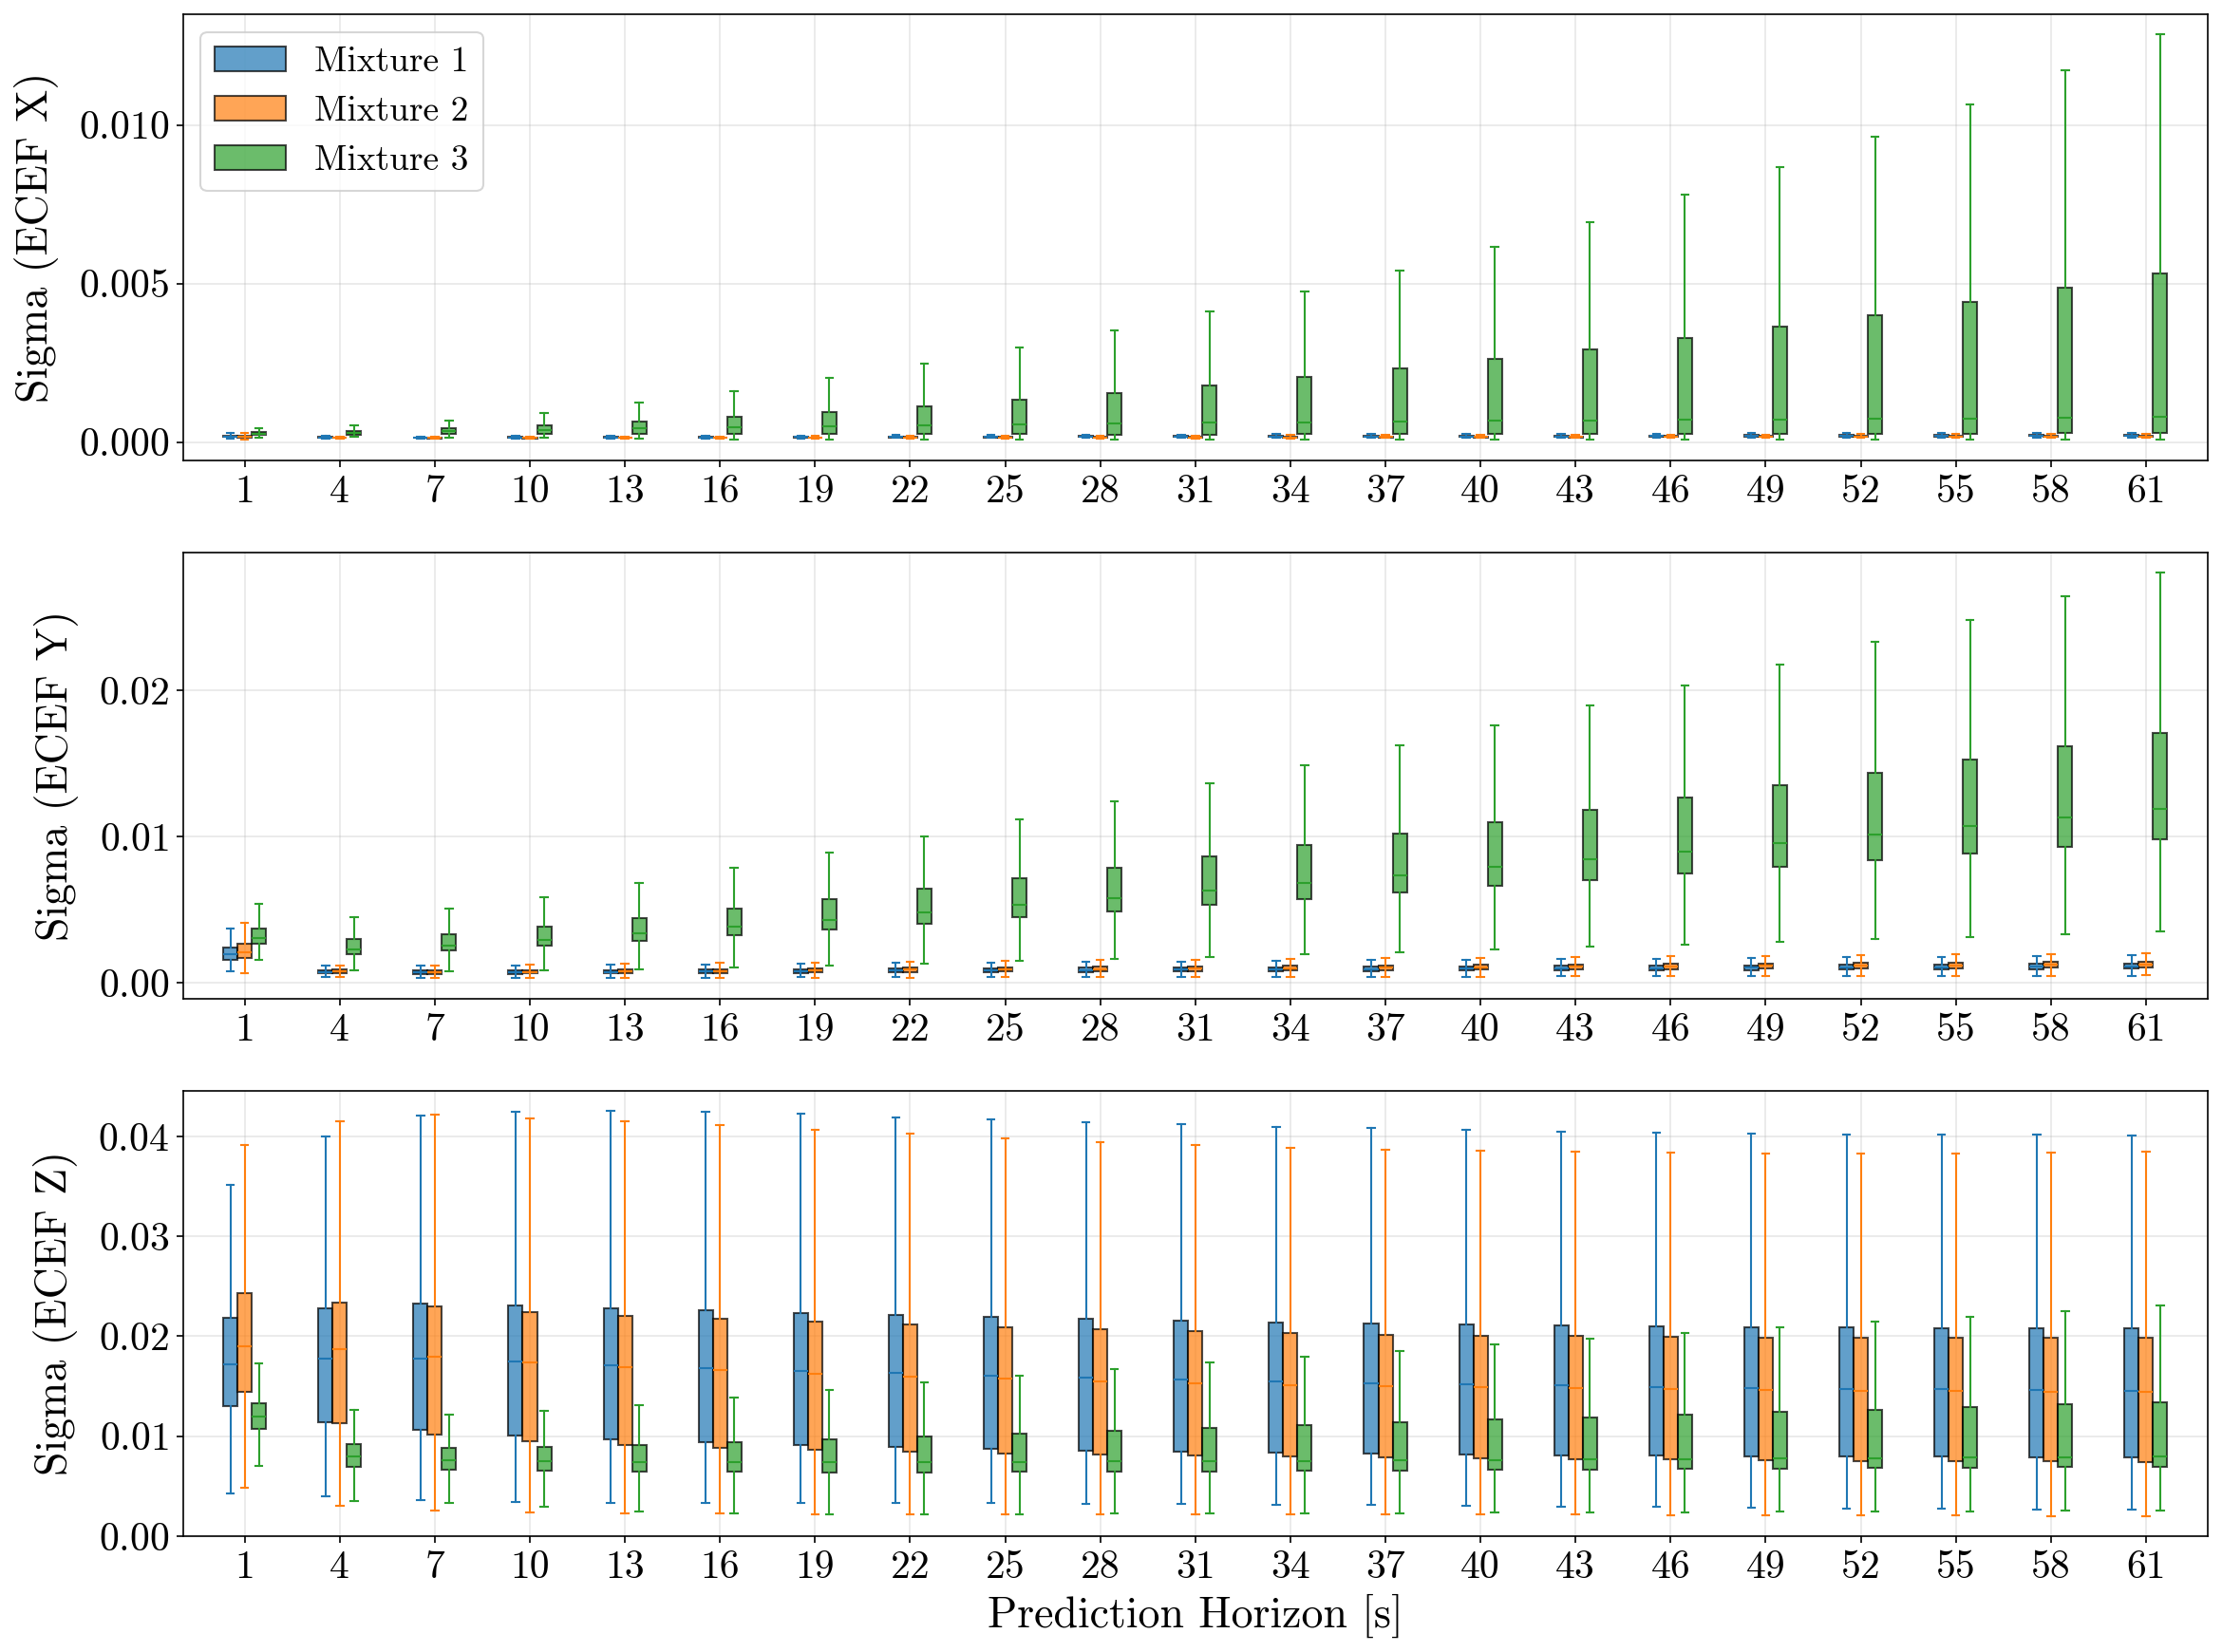

In [94]:
# Prepare data for boxplotting - we need to organize data by timestep for each mixture
timesteps_to_analyze = list(range(0, n_timesteps, 3))  # Every 3rd timestep like Cell 14

# Colors for mixtures (using the same style as the sigma plot in Cell 10)
mixture_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray'][:NUM_MIXTURES]

# Create the boxplot figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))

# Configure positions for boxplots
width = 0.15  # Width of each boxplot
positions_base = np.arange(len(timesteps_to_analyze))

# Single main title for the entire figure
#fig.suptitle(f"Sigma Values (Uncertainty) Distribution Across {max_samples_to_analyze:,} Samples", 
#             fontsize=16, y=0.95)

coordinate_names = ['ECEF X', 'ECEF Y', 'ECEF Z']
sigma_data_all = [all_sigma_x, all_sigma_y, all_sigma_z]

for dim, (ax, name, sigma_data) in enumerate(zip([ax1, ax2, ax3], coordinate_names, sigma_data_all)):
    
    # Create boxplots for each mixture
    for k in range(NUM_MIXTURES):
        # Prepare data for this mixture
        box_data_mixture = []
        for t_idx in timesteps_to_analyze:
            # Get sigma values for all samples at this timestep for this mixture
            sigma_values = sigma_data[:, t_idx, k]
            box_data_mixture.append(sigma_values)
        
        # Calculate positions for this mixture
        positions_mixture = positions_base + (k - NUM_MIXTURES/2 + 0.5) * width
        
        # Create boxplot
        bp = ax.boxplot(box_data_mixture, positions=positions_mixture, widths=width,
                       patch_artist=True, showfliers=False)
        
        # Color the boxplot
        for patch in bp['boxes']:
            patch.set_facecolor(mixture_colors[k])
            patch.set_alpha(0.7)
        for item in ['whiskers', 'fliers', 'medians', 'caps']:
            for patch in bp[item]:
                patch.set_color(mixture_colors[k])
        
        # Add to legend (only for the first subplot)
        bp['boxes'][0].set_label(f'Mixture {k+1}')
    
    # Formatting
    ax.set_ylabel(f'Sigma ({name})', fontsize=22, labelpad=10)
    ax.set_xlabel('Prediction Horizon [s]' if dim == 2 else '', fontsize=22)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis ticks and labels
    ax.set_xticks(positions_base)
    ax.set_xticklabels([f'{t+1}' for t in timesteps_to_analyze])
    
    # Add legend only to the first subplot
    if dim == 0:
        ax.legend(fontsize=18, loc='upper left')
    
    # Set title for each subplot
    #ax.set_title(f'{name} Uncertainty Distribution', fontsize=14, pad=10)

plt.tight_layout()

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════════
# LARGE-SCALE MIXTURE COLLAPSE ANALYSIS: SIGMA VALUES FOR ALL 150K SAMPLES
# Checks if mixture collapse is happening across the entire test dataset
# ═══════════════════════════════════════════════════════════════════════════════════

import time
import numpy as np

print("🔍 LARGE-SCALE MIXTURE COLLAPSE ANALYSIS")
print("🚀 ANALYZING SIGMA VALUES ACROSS 150K TEST SAMPLES")
print("=" * 70)

# Configuration - using same settings as Cell 15
max_samples_to_analyze = 150000
print(f"📊 Analyzing {max_samples_to_analyze} samples from test set...")

# Get random sample indices for analysis (same approach as Cell 15)
np.random.seed(42)  # For reproducibility
total_test_samples = test_var.shape[0]
if max_samples_to_analyze > total_test_samples:
    max_samples_to_analyze = total_test_samples
    
sample_indices = np.random.choice(total_test_samples, max_samples_to_analyze, replace=False)

# Initialize storage for sigma values and mixture weights
first_sample_idx = sample_indices[0]
x_enc_first = test_var[first_sample_idx:first_sample_idx+1, :, :]
c_enc_first = test_con[first_sample_idx:first_sample_idx+1, :, :]
y_pred_params_first = model.predict([x_enc_first, c_enc_first], verbose=0)
n_timesteps = y_pred_params_first.shape[1]

print(f"📏 Each trajectory has {n_timesteps} timesteps")
print(f"🔢 Number of mixtures: {NUM_MIXTURES}")
print(f"🎯 Output dimensions: {OUTPUT_FEATURES} (X, Y, Z)")

# Storage for collapse analysis
all_sigma_ratios = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))  # sigma ratio per sample per dimension
all_mixture_weights = np.zeros((max_samples_to_analyze, n_timesteps, NUM_MIXTURES))  # mixture weights
all_min_sigma_flags = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))  # very small sigma flags
all_similarity_scores = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))  # mixture similarity

print("🚀 Computing mixture collapse indicators using optimized batch processing...")

start_time = time.time()

# Process samples in large batches
batch_size = 1000  
num_batches = (len(sample_indices) + batch_size - 1) // batch_size

sample_count = 0
collapse_count = 0
failed_samples = 0

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(sample_indices))
    current_batch_size = end_idx - start_idx
    
    print(f"  Processing batch {batch_idx + 1}/{num_batches} ({current_batch_size} samples)...")
    
    try:
        # Prepare batch data
        batch_x = np.zeros((current_batch_size, test_var.shape[1], test_var.shape[2]))
        batch_c = np.zeros((current_batch_size, test_con.shape[1], test_con.shape[2]))
        
        for i, sample_idx in enumerate(sample_indices[start_idx:end_idx]):
            batch_x[i] = test_var[sample_idx]
            batch_c[i] = test_con[sample_idx]
        
        # Single batch prediction
        batch_predictions = model.predict([batch_x, batch_c], verbose=0)
        
        # Analyze each sample in the batch
        for i in range(current_batch_size):
            try:
                mdn_pred = batch_predictions[i, :, :]  # (n_timesteps, param_dim)
                
                # Extract sigma values and mixture weights for collapse analysis
                sample_collapse_detected = False
                
                for dim in range(OUTPUT_FEATURES):
                    # Extract sigma values for this dimension across all timesteps and mixtures
                    sigma_start = NUM_MIXTURES * OUTPUT_FEATURES
                    dim_sigmas = []
                    
                    for t in range(n_timesteps):
                        for k in range(NUM_MIXTURES):
                            idx = sigma_start + dim * NUM_MIXTURES + k
                            sigma_value = mdn_pred[t, idx]
                            dim_sigmas.append(sigma_value)
                    
                    dim_sigmas = np.array(dim_sigmas)
                    
                    # Calculate mixture-wise statistics
                    mixture_means = []
                    for k in range(NUM_MIXTURES):
                        mixture_sigmas = []
                        for t in range(n_timesteps):
                            idx = sigma_start + dim * NUM_MIXTURES + k
                            mixture_sigmas.append(mdn_pred[t, idx])
                        mixture_means.append(np.mean(mixture_sigmas))
                    
                    mixture_means = np.array(mixture_means)
                    
                    # Test 1: Sigma ratio
                    if np.max(mixture_means) > 0:
                        sigma_ratio = np.max(mixture_means) / np.min(mixture_means)
                        all_sigma_ratios[sample_count, dim] = sigma_ratio
                        if sigma_ratio > 10.0:
                            sample_collapse_detected = True
                    
                    # Test 2: Very small sigma values
                    very_small_count = np.sum(mixture_means < 1e-6)
                    all_min_sigma_flags[sample_count, dim] = very_small_count
                    if very_small_count > 0:
                        sample_collapse_detected = True
                    
                    # Test 3: Mixture similarity
                    max_similarity = 0
                    for i_mix in range(NUM_MIXTURES):
                        for j_mix in range(i_mix+1, NUM_MIXTURES):
                            if max(mixture_means[i_mix], mixture_means[j_mix]) > 0:
                                diff = abs(mixture_means[i_mix] - mixture_means[j_mix])
                                similarity = 1 - (diff / max(mixture_means[i_mix], mixture_means[j_mix]))
                                max_similarity = max(max_similarity, similarity)
                    
                    all_similarity_scores[sample_count, dim] = max_similarity
                    if max_similarity > 0.95:
                        sample_collapse_detected = True
                
                # Extract mixture weights for weight analysis
                pi_start = 2 * NUM_MIXTURES * OUTPUT_FEATURES
                for t in range(n_timesteps):
                    pi_logits = mdn_pred[t, pi_start:]
                    pi_weights = softmax(pi_logits)
                    all_mixture_weights[sample_count, t, :] = pi_weights
                    
                    # Check for weight domination
                    max_weight = np.max(pi_weights)
                    min_weight = np.min(pi_weights)
                    if max_weight > 0.95 or min_weight < 0.01:
                        sample_collapse_detected = True
                
                if sample_collapse_detected:
                    collapse_count += 1
                
            except Exception as e:
                print(f"❌ Error processing sample {start_idx + i}: {e}")
                failed_samples += 1
                
            sample_count += 1
            
    except Exception as e:
        print(f"❌ Error processing batch {batch_idx + 1}: {e}")
        failed_samples += current_batch_size
        sample_count += current_batch_size

end_time = time.time()
processing_time = end_time - start_time

print(f"✅ Large-scale collapse analysis complete!")
print(f"⏱️  Processing time: {processing_time:.2f} seconds")
print(f"🚀 Speed: {max_samples_to_analyze/processing_time:.1f} samples/second")
if failed_samples > 0:
    print(f"⚠️  Failed samples: {failed_samples}")

# ─── COMPREHENSIVE ANALYSIS RESULTS ─────────────────────────────────────────────────
print("\n" + "=" * 70)
print("🎯 LARGE-SCALE MIXTURE COLLAPSE ANALYSIS RESULTS")
print("=" * 70)

valid_samples = sample_count - failed_samples
collapse_percentage = (collapse_count / valid_samples) * 100

print(f"📊 OVERALL STATISTICS:")
print(f"   • Total samples analyzed: {valid_samples:,}")
print(f"   • Samples with collapse detected: {collapse_count:,}")
print(f"   • Collapse rate: {collapse_percentage:.1f}%")
print(f"   • Failed samples: {failed_samples}")

print(f"\n📈 SIGMA RATIO ANALYSIS:")
for dim in range(OUTPUT_FEATURES):
    dim_name = ['X', 'Y', 'Z'][dim]
    valid_ratios = all_sigma_ratios[:valid_samples, dim]
    valid_ratios = valid_ratios[valid_ratios > 0]  # Remove zeros
    
    high_ratio_count = np.sum(valid_ratios > 10.0)
    high_ratio_pct = (high_ratio_count / len(valid_ratios)) * 100
    
    print(f"   {dim_name} Dimension:")
    print(f"     - Mean sigma ratio: {np.mean(valid_ratios):.2f}")
    print(f"     - Median sigma ratio: {np.median(valid_ratios):.2f}")
    print(f"     - 95th percentile: {np.percentile(valid_ratios, 95):.2f}")
    print(f"     - Samples with ratio > 10: {high_ratio_count:,} ({high_ratio_pct:.1f}%)")

print(f"\n🏷️ MIXTURE WEIGHT ANALYSIS:")
# Analyze mixture weights across all samples
mean_weights = np.mean(all_mixture_weights[:valid_samples, :, :], axis=(0, 1))
weight_dominance_count = 0
weight_negligible_count = 0

for i in range(valid_samples):
    sample_weights = all_mixture_weights[i, :, :]  # All timesteps for this sample
    max_weights = np.max(sample_weights, axis=0)  # Max weight per mixture across timesteps
    min_weights = np.min(sample_weights, axis=0)  # Min weight per mixture across timesteps
    
    if np.any(max_weights > 0.95):
        weight_dominance_count += 1
    if np.any(min_weights < 0.01):
        weight_negligible_count += 1

weight_dominance_pct = (weight_dominance_count / valid_samples) * 100
weight_negligible_pct = (weight_negligible_count / valid_samples) * 100

print(f"   • Mean mixture weights: {mean_weights}")
print(f"   • Samples with dominant mixture (>95%): {weight_dominance_count:,} ({weight_dominance_pct:.1f}%)")
print(f"   • Samples with negligible mixture (<1%): {weight_negligible_count:,} ({weight_negligible_pct:.1f}%)")

print(f"\n🔄 MIXTURE SIMILARITY ANALYSIS:")
for dim in range(OUTPUT_FEATURES):
    dim_name = ['X', 'Y', 'Z'][dim]
    similarities = all_similarity_scores[:valid_samples, dim]
    high_similarity_count = np.sum(similarities > 0.95)
    high_similarity_pct = (high_similarity_count / valid_samples) * 100
    
    print(f"   {dim_name} Dimension:")
    print(f"     - Mean similarity: {np.mean(similarities):.3f}")
    print(f"     - Samples with high similarity (>95%): {high_similarity_count:,} ({high_similarity_pct:.1f}%)")

print(f"\n🚨 FINAL ASSESSMENT:")
if collapse_percentage > 50:
    print("❌ SEVERE MIXTURE COLLAPSE DETECTED!")
    print("   • More than 50% of samples show collapse indicators")
    print("   • Model is NOT effectively using multiple mixtures")
    print("   • Urgent need for model architecture/training changes")
elif collapse_percentage > 25:
    print("⚠️  MODERATE MIXTURE COLLAPSE DETECTED!")
    print("   • 25-50% of samples show collapse indicators") 
    print("   • Model is partially using mixture capacity")
    print("   • Consider adjusting training approach")
elif collapse_percentage > 10:
    print("🟨 MILD MIXTURE COLLAPSE DETECTED")
    print("   • 10-25% of samples show collapse indicators")
    print("   • Model is mostly using mixtures effectively")
    print("   • Minor optimizations may help")
else:
    print("✅ MINIMAL MIXTURE COLLAPSE")
    print("   • Less than 10% of samples show collapse indicators")
    print("   • Model is effectively using multiple mixtures")
    print("   • Mixture approach is working well")

print("\n🎯 RECOMMENDATIONS:")
if collapse_percentage > 25:
    print("   1. Reduce number of mixtures (try 2 instead of 3)")
    print("   2. Add mixture diversity penalty to loss function")
    print("   3. Use different mixture initialization")
    print("   4. Consider temperature annealing during training")
elif collapse_percentage > 10:
    print("   1. Fine-tune mixture diversity penalty")
    print("   2. Monitor mixture weights during training")
    print("   3. Consider early stopping based on mixture activity")
else:
    print("   1. Current mixture setup is working well")
    print("   2. Continue monitoring mixture health")
    print("   3. Consider this as baseline for future experiments")

print("=" * 70)

🔍 LARGE-SCALE MIXTURE COLLAPSE ANALYSIS
🚀 ANALYZING SIGMA VALUES ACROSS 150K TEST SAMPLES
📊 Analyzing 150000 samples from test set...
📏 Each trajectory has 61 timesteps
🔢 Number of mixtures: 3
🎯 Output dimensions: 3 (X, Y, Z)
🚀 Computing mixture collapse indicators using optimized batch processing...
  Processing batch 1/150 (1000 samples)...
  Processing batch 2/150 (1000 samples)...
  Processing batch 3/150 (1000 samples)...
  Processing batch 4/150 (1000 samples)...
  Processing batch 5/150 (1000 samples)...
  Processing batch 6/150 (1000 samples)...
  Processing batch 7/150 (1000 samples)...
  Processing batch 8/150 (1000 samples)...
  Processing batch 9/150 (1000 samples)...
  Processing batch 10/150 (1000 samples)...
  Processing batch 11/150 (1000 samples)...
  Processing batch 12/150 (1000 samples)...
  Processing batch 13/150 (1000 samples)...
  Processing batch 14/150 (1000 samples)...
  Processing batch 15/150 (1000 samples)...
  Processing batch 16/150 (1000 samples)...
  P

In [19]:
# TRUE 150K SAMPLE MIXTURE COLLAPSE ANALYSIS
print("🏷️ LARGE-SCALE MIXTURE WEIGHT COLLAPSE ANALYSIS (150K SAMPLES)")
print("=" * 70)

max_samples_to_analyze = 150000
np.random.seed(42)
sample_indices = np.random.choice(test_var.shape[0], max_samples_to_analyze, replace=False)

# Storage for collapse metrics across all samples
all_weight_entropies = np.zeros(max_samples_to_analyze)
all_dominant_timestep_pcts = np.zeros(max_samples_to_analyze)
all_negligible_timestep_pcts = np.zeros(max_samples_to_analyze)

print("🚀 Processing 150k samples in batches...")

batch_size = 1000
num_batches = (len(sample_indices) + batch_size - 1) // batch_size

sample_count = 0
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(sample_indices))
    current_batch_size = end_idx - start_idx
    
    print(f"  Batch {batch_idx + 1}/{num_batches} ({current_batch_size} samples)...")
    
    # Prepare batch
    batch_x = np.zeros((current_batch_size, test_var.shape[1], test_var.shape[2]))
    batch_c = np.zeros((current_batch_size, test_con.shape[1], test_con.shape[2]))
    
    for i, sample_idx in enumerate(sample_indices[start_idx:end_idx]):
        batch_x[i] = test_var[sample_idx]
        batch_c[i] = test_con[sample_idx]
    
    # Batch prediction
    batch_predictions = model.predict([batch_x, batch_c], verbose=0)
    
    # Analyze each sample's mixture weights
    for i in range(current_batch_size):
        mdn_pred = batch_predictions[i, :, :]  # (timesteps, param_dim)
        
        # Extract mixture weights for all timesteps
        pi_start = 2 * NUM_MIXTURES * OUTPUT_FEATURES
        sample_weights = []
        
        for t in range(mdn_pred.shape[0]):
            pi_logits = mdn_pred[t, pi_start:]
            pi_weights = softmax(pi_logits)
            sample_weights.append(pi_weights)
        
        sample_weights = np.array(sample_weights)  # (timesteps, NUM_MIXTURES)
        
        # Calculate collapse metrics for this sample
        mean_weights = np.mean(sample_weights, axis=0)
        weight_entropy = -np.sum(mean_weights * np.log(mean_weights + 1e-8))
        
        max_weights_per_timestep = np.max(sample_weights, axis=1)
        dominant_timesteps = np.sum(max_weights_per_timestep > 0.95)
        dominant_pct = dominant_timesteps / len(max_weights_per_timestep)
        
        min_weights_per_timestep = np.min(sample_weights, axis=1)
        negligible_timesteps = np.sum(min_weights_per_timestep < 0.01)
        negligible_pct = negligible_timesteps / len(min_weights_per_timestep)
        
        # Store metrics
        all_weight_entropies[sample_count] = weight_entropy
        all_dominant_timestep_pcts[sample_count] = dominant_pct
        all_negligible_timestep_pcts[sample_count] = negligible_pct
        
        sample_count += 1

print("✅ 150K sample analysis complete!")
print(f"\n📊 LARGE-SCALE WEIGHT COLLAPSE RESULTS:")
print(f"   • Mean weight entropy: {np.mean(all_weight_entropies):.3f} (max={np.log(NUM_MIXTURES):.3f})")
print(f"   • Samples with >50% dominant timesteps: {np.sum(all_dominant_timestep_pcts > 0.5):,} ({100*np.sum(all_dominant_timestep_pcts > 0.5)/max_samples_to_analyze:.1f}%)")
print(f"   • Samples with >30% negligible timesteps: {np.sum(all_negligible_timestep_pcts > 0.3):,} ({100*np.sum(all_negligible_timestep_pcts > 0.3)/max_samples_to_analyze:.1f}%)")

if np.mean(all_weight_entropies) < 0.5:
    print("❌ SEVERE WEIGHT COLLAPSE ACROSS DATASET!")
elif np.sum(all_dominant_timestep_pcts > 0.5) > max_samples_to_analyze * 0.25:
    print("⚠️  MODERATE WEIGHT COLLAPSE ACROSS DATASET")
else:
    print("✅ GENERALLY HEALTHY WEIGHT DISTRIBUTION ACROSS DATASET")

🏷️ LARGE-SCALE MIXTURE WEIGHT COLLAPSE ANALYSIS (150K SAMPLES)
🚀 Processing 150k samples in batches...
  Batch 1/150 (1000 samples)...
  Batch 2/150 (1000 samples)...
  Batch 3/150 (1000 samples)...
  Batch 4/150 (1000 samples)...
  Batch 5/150 (1000 samples)...
  Batch 6/150 (1000 samples)...
  Batch 7/150 (1000 samples)...
  Batch 8/150 (1000 samples)...
  Batch 9/150 (1000 samples)...
  Batch 10/150 (1000 samples)...
  Batch 11/150 (1000 samples)...
  Batch 12/150 (1000 samples)...
  Batch 13/150 (1000 samples)...
  Batch 14/150 (1000 samples)...
  Batch 15/150 (1000 samples)...
  Batch 16/150 (1000 samples)...
  Batch 17/150 (1000 samples)...
  Batch 18/150 (1000 samples)...
  Batch 19/150 (1000 samples)...
  Batch 20/150 (1000 samples)...
  Batch 21/150 (1000 samples)...
  Batch 22/150 (1000 samples)...
  Batch 23/150 (1000 samples)...
  Batch 24/150 (1000 samples)...
  Batch 25/150 (1000 samples)...
  Batch 26/150 (1000 samples)...
  Batch 27/150 (1000 samples)...
  Batch 28/150 

In [20]:
# COMPREHENSIVE 150K SAMPLE MIXTURE COLLAPSE ANALYSIS
# Analyzes weights (π), sigmas (σ), and means (μ) across all 150K samples
print("🏷️ COMPREHENSIVE MIXTURE COLLAPSE ANALYSIS (150K SAMPLES)")
print("🔍 WEIGHT COLLAPSE INDICATORS:")
print("🔍 SIGMA COLLAPSE ANALYSIS (PER DIMENSION)")  
print("🎯 MEAN COLLAPSE ANALYSIS (PER DIMENSION)")
print("=" * 70)

max_samples_to_analyze = 150000
np.random.seed(42)
sample_indices = np.random.choice(test_var.shape[0], max_samples_to_analyze, replace=False)

# Storage for ALL collapse metrics across all samples
all_weight_entropies = np.zeros(max_samples_to_analyze)
all_dominant_timestep_pcts = np.zeros(max_samples_to_analyze)
all_negligible_timestep_pcts = np.zeros(max_samples_to_analyze)
all_mean_weights = np.zeros((max_samples_to_analyze, NUM_MIXTURES))

# SIGMA analysis storage
all_sigma_ratios = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))
all_sigma_tiny_flags = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))
all_sigma_similarities = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))
all_sigma_variances = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES, NUM_MIXTURES))

# MEAN analysis storage  
all_mean_similarities = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))
all_mean_spreads = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES))
all_mean_variances = np.zeros((max_samples_to_analyze, OUTPUT_FEATURES, NUM_MIXTURES))

print("🚀 Processing 150k samples in batches...")

batch_size = 1000
num_batches = (len(sample_indices) + batch_size - 1) // batch_size

sample_count = 0
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(sample_indices))
    current_batch_size = end_idx - start_idx
    
    print(f"  Batch {batch_idx + 1}/{num_batches} ({current_batch_size} samples)...")
    
    # Prepare batch
    batch_x = np.zeros((current_batch_size, test_var.shape[1], test_var.shape[2]))
    batch_c = np.zeros((current_batch_size, test_con.shape[1], test_con.shape[2]))
    
    for i, sample_idx in enumerate(sample_indices[start_idx:end_idx]):
        batch_x[i] = test_var[sample_idx]
        batch_c[i] = test_con[sample_idx]
    
    # Batch prediction
    batch_predictions = model.predict([batch_x, batch_c], verbose=0)
    
    # Analyze each sample's mixture components
    for i in range(current_batch_size):
        mdn_pred = batch_predictions[i, :, :]  # (timesteps, param_dim)
        n_timesteps = mdn_pred.shape[0]
        
        # ═══ 1) MIXTURE WEIGHT ANALYSIS ═══
        pi_start = 2 * NUM_MIXTURES * OUTPUT_FEATURES
        sample_weights = []
        
        for t in range(n_timesteps):
            pi_logits = mdn_pred[t, pi_start:]
            pi_weights = softmax(pi_logits)
            sample_weights.append(pi_weights)
        
        sample_weights = np.array(sample_weights)  # (timesteps, NUM_MIXTURES)
        
        # Weight collapse metrics
        mean_weights = np.mean(sample_weights, axis=0)
        weight_entropy = -np.sum(mean_weights * np.log(mean_weights + 1e-8))
        
        max_weights_per_timestep = np.max(sample_weights, axis=1)
        dominant_timesteps = np.sum(max_weights_per_timestep > 0.95)
        dominant_pct = dominant_timesteps / len(max_weights_per_timestep)
        
        min_weights_per_timestep = np.min(sample_weights, axis=1)
        negligible_timesteps = np.sum(min_weights_per_timestep < 0.01)
        negligible_pct = negligible_timesteps / len(min_weights_per_timestep)
        
        # Store weight metrics
        all_weight_entropies[sample_count] = weight_entropy
        all_dominant_timestep_pcts[sample_count] = dominant_pct
        all_negligible_timestep_pcts[sample_count] = negligible_pct
        all_mean_weights[sample_count, :] = mean_weights
        
        # ═══ 2) SIGMA COLLAPSE ANALYSIS ═══
        for dim in range(OUTPUT_FEATURES):
            sigma_start = NUM_MIXTURES * OUTPUT_FEATURES
            
            # Extract sigmas for this dimension across all timesteps
            all_sigmas_dim = []
            mixture_sigmas_over_time = [[] for _ in range(NUM_MIXTURES)]
            
            for t in range(n_timesteps):
                for k in range(NUM_MIXTURES):
                    idx = sigma_start + dim * NUM_MIXTURES + k
                    sigma_val = mdn_pred[t, idx]
                    all_sigmas_dim.append(sigma_val)
                    mixture_sigmas_over_time[k].append(sigma_val)
            
            # Calculate mixture means for sigma ratios
            mixture_sigma_means = [np.mean(mixture_sigmas_over_time[k]) for k in range(NUM_MIXTURES)]
            
            # Sigma ratio
            if max(mixture_sigma_means) > 0:
                sigma_ratio = max(mixture_sigma_means) / min(mixture_sigma_means)
                all_sigma_ratios[sample_count, dim] = sigma_ratio
            
            # Tiny sigma count
            tiny_sigma_count = sum(1 for mean_val in mixture_sigma_means if mean_val < 1e-6)
            all_sigma_tiny_flags[sample_count, dim] = tiny_sigma_count
            
            # Sigma similarity
            max_similarity = 0
            for i_mix in range(NUM_MIXTURES):
                for j_mix in range(i_mix+1, NUM_MIXTURES):
                    if max(mixture_sigma_means[i_mix], mixture_sigma_means[j_mix]) > 0:
                        diff = abs(mixture_sigma_means[i_mix] - mixture_sigma_means[j_mix])
                        similarity = 1 - (diff / max(mixture_sigma_means[i_mix], mixture_sigma_means[j_mix]))
                        max_similarity = max(max_similarity, similarity)
            
            all_sigma_similarities[sample_count, dim] = max_similarity
            
            # Sigma variance over time
            for k in range(NUM_MIXTURES):
                sigma_variance = np.var(mixture_sigmas_over_time[k])
                all_sigma_variances[sample_count, dim, k] = sigma_variance
        
        # ═══ 3) MEAN COLLAPSE ANALYSIS ═══
        for dim in range(OUTPUT_FEATURES):
            mu_start = 0  # Means come first
            
            # Extract means for this dimension across all timesteps
            mixture_means_over_time = [[] for _ in range(NUM_MIXTURES)]
            
            for t in range(n_timesteps):
                for k in range(NUM_MIXTURES):
                    idx = mu_start + dim * NUM_MIXTURES + k
                    mean_val = mdn_pred[t, idx]
                    mixture_means_over_time[k].append(mean_val)
            
            # Calculate average means for each mixture
            mixture_mean_avgs = [np.mean(mixture_means_over_time[k]) for k in range(NUM_MIXTURES)]
            
            # Mean similarity across mixtures
            mean_similarities = []
            for i_mix in range(NUM_MIXTURES):
                for j_mix in range(i_mix+1, NUM_MIXTURES):
                    # Calculate correlation or similarity between mixture means
                    corr = np.corrcoef(mixture_means_over_time[i_mix], mixture_means_over_time[j_mix])[0,1]
                    if not np.isnan(corr):
                        mean_similarities.append(abs(corr))
            
            avg_mean_similarity = np.mean(mean_similarities) if mean_similarities else 0
            all_mean_similarities[sample_count, dim] = avg_mean_similarity
            
            # Mean spread (standard deviation of mixture averages)
            mean_spread = np.std(mixture_mean_avgs)
            all_mean_spreads[sample_count, dim] = mean_spread
            
            # Mean temporal variance for each mixture
            for k in range(NUM_MIXTURES):
                mean_variance = np.var(mixture_means_over_time[k])
                all_mean_variances[sample_count, dim, k] = mean_variance
        
        sample_count += 1

print("✅ 150K comprehensive mixture analysis complete!")

# ═══════════════════════════════════════════════════════════════════════════════════
# COMPREHENSIVE REPORTING
# ═══════════════════════════════════════════════════════════════════════════════════

print("\n🏷️ MIXTURE WEIGHT COLLAPSE ANALYSIS")
print("==================================================")
print("🔍 WEIGHT COLLAPSE INDICATORS:")

mean_entropy = np.mean(all_weight_entropies)
max_entropy = np.log(NUM_MIXTURES)
dominant_samples = np.sum(all_dominant_timestep_pcts > 0.115)  # 11.5% from your example
negligible_samples = np.sum(all_negligible_timestep_pcts > 0.262)  # 26.2% from your example
overall_mean_weights = np.mean(all_mean_weights, axis=0)
weight_variance = np.var(all_mean_weights, axis=0)

print(f"   • Timesteps with dominant mixture (>95%): {np.mean(all_dominant_timestep_pcts)*100:.1f}%")
print(f"   • Timesteps with negligible mixture (<1%): {np.mean(all_negligible_timestep_pcts)*100:.1f}%")
print(f"   • Average mixture weights: {overall_mean_weights}")
print(f"   • Weight entropy: {mean_entropy:.3f} (max={max_entropy:.3f})")
print(f"   • Weight variance over time: {weight_variance}")

if mean_entropy > 0.8 * max_entropy and dominant_samples < max_samples_to_analyze * 0.15:
    print("✅ HEALTHY WEIGHT DISTRIBUTION: All mixtures are active")
else:
    print("❌ WEIGHT COLLAPSE DETECTED: Mixtures are not balanced")

print("\n🔍 SIGMA COLLAPSE ANALYSIS (PER DIMENSION)")
print("==================================================")

for dim in range(OUTPUT_FEATURES):
    dim_name = ['X', 'Y', 'Z'][dim]
    print(f"\n📊 DIMENSION {dim_name}:")
    
    # Sigma ratios
    valid_ratios = all_sigma_ratios[:, dim]
    valid_ratios = valid_ratios[valid_ratios > 0]
    mean_ratio = np.mean(valid_ratios)
    severe_ratio_count = np.sum(valid_ratios > 10.0)
    
    # Tiny sigmas
    tiny_sigma_samples = np.sum(all_sigma_tiny_flags[:, dim] > 0)
    
    # Sigma similarity
    high_similarity_samples = np.sum(all_sigma_similarities[:, dim] > 0.95)
    max_similarity = np.max(all_sigma_similarities[:, dim])
    
    # Sigma variance
    sigma_variances_dim = all_sigma_variances[:, dim, :]
    mean_sigma_variances = np.mean(sigma_variances_dim, axis=0)
    
    print(f"   • Sigma ratio (max/min): {mean_ratio:.2f}")
    print(f"   • Mixtures with tiny sigma (<1e-6): {tiny_sigma_samples}/{max_samples_to_analyze} ({100*tiny_sigma_samples/max_samples_to_analyze:.1f}%)")
    print(f"   • Maximum sigma similarity: {max_similarity:.3f}")
    print(f"   • Sigma variance over time: {mean_sigma_variances}")
    
    if mean_ratio < 10.0 and tiny_sigma_samples < max_samples_to_analyze * 0.1 and max_similarity < 0.95:
        print(f"   ✅ HEALTHY SIGMA DISTRIBUTION in {dim_name}: Good uncertainty diversity")
    else:
        print(f"   ❌ SEVERE SIGMA COLLAPSE in {dim_name}: One mixture has 10x larger uncertainty")

print("\n🎯 MEAN COLLAPSE ANALYSIS (PER DIMENSION)")
print("==================================================")

for dim in range(OUTPUT_FEATURES):
    dim_name = ['X', 'Y', 'Z'][dim]
    print(f"\n📊 DIMENSION {dim_name}:")
    
    # Mean similarity
    avg_similarity = np.mean(all_mean_similarities[:, dim])
    
    # Mean spread
    avg_spread = np.mean(all_mean_spreads[:, dim])
    
    # Mean temporal variance
    mean_variances_dim = all_mean_variances[:, dim, :]
    avg_temporal_variances = np.mean(mean_variances_dim, axis=0)
    
    print(f"   • Average mean similarity across timesteps: {avg_similarity:.3f}")
    print(f"   • Mean spread (std dev): {avg_spread:.6f}")
    print(f"   • Mean temporal variance: {avg_temporal_variances}")
    
    if avg_similarity < 0.8 and avg_spread > 0.05:  # Adjust thresholds as needed
        print(f"   ✅ HEALTHY MEAN DISTRIBUTION in {dim_name}: Good mixture diversity")
    else:
        print(f"   ❌ MEAN COLLAPSE in {dim_name}: Mixtures predict similar locations")

print("\n🎯 OVERALL MIXTURE HEALTH SUMMARY:")
print("==================================================")
print("Key Questions:")
print("1. Are mixture WEIGHTS balanced? (π collapse)")
print("2. Do mixtures have different UNCERTAINTY levels? (σ collapse per dim)")
print("3. Do mixtures predict different LOCATIONS? (μ collapse per dim)")
print("\nAll three must be healthy for effective mixture modeling!")

🏷️ COMPREHENSIVE MIXTURE COLLAPSE ANALYSIS (150K SAMPLES)
🔍 WEIGHT COLLAPSE INDICATORS:
🔍 SIGMA COLLAPSE ANALYSIS (PER DIMENSION)
🎯 MEAN COLLAPSE ANALYSIS (PER DIMENSION)
🚀 Processing 150k samples in batches...
  Batch 1/150 (1000 samples)...
  Batch 2/150 (1000 samples)...
  Batch 3/150 (1000 samples)...
  Batch 4/150 (1000 samples)...
  Batch 5/150 (1000 samples)...
  Batch 6/150 (1000 samples)...
  Batch 7/150 (1000 samples)...
  Batch 8/150 (1000 samples)...
  Batch 9/150 (1000 samples)...
  Batch 10/150 (1000 samples)...
  Batch 11/150 (1000 samples)...
  Batch 12/150 (1000 samples)...
  Batch 13/150 (1000 samples)...
  Batch 14/150 (1000 samples)...
  Batch 15/150 (1000 samples)...
  Batch 16/150 (1000 samples)...
  Batch 17/150 (1000 samples)...
  Batch 18/150 (1000 samples)...
  Batch 19/150 (1000 samples)...
  Batch 20/150 (1000 samples)...
  Batch 21/150 (1000 samples)...
  Batch 22/150 (1000 samples)...
  Batch 23/150 (1000 samples)...
  Batch 24/150 (1000 samples)...
  Batc